In [1]:
# Cell 1: Imports and Setup for Multi-Class Segmentation
import sys
sys.path.append('CIPS-Net')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import albumentations as A
from collections import Counter

# Reload CIPS-Net modules
modules_to_reload = [
    'CIPS-Net.models.image_encoder',
    'CIPS-Net.models.text_encoder',
    'CIPS-Net.models.instruction_grounding',
    'CIPS-Net.models.decoder',
    'CIPS-Net.models.cips_net',
    'CIPS-Net.models'
]
for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

from models.cips_net import CIPSNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("=" * 60)
print("MULTI-CLASS SEGMENTATION PIPELINE (5 Classes)")
print("=" * 60)
print("Classes: Neoplastic, Inflammatory, Connective_Soft_tissue, Epithelial, Dead")
print("Output: Raw logits (B, 5, H, W) - NO sigmoid")
print("GT: Class index mask (B, H, W) with values {0,1,2,3,4}")
print("=" * 60)
print("✓ All imports loaded!")

Using device: cuda
MULTI-CLASS SEGMENTATION PIPELINE (5 Classes)
Classes: Neoplastic, Inflammatory, Connective_Soft_tissue, Epithelial, Dead
Output: Raw logits (B, 5, H, W) - NO sigmoid
GT: Class index mask (B, H, W) with values {0,1,2,3,4}
✓ All imports loaded!


## 1. Load Dataset and Define Class Mapping

In [2]:
# Cell 2: Load Dataset and Class Configuration
df = pd.read_csv('Dataset/Images_With_Permutations_Labels_Refer_Segmentation_Task.csv')
print(f"Dataset loaded: {len(df)} total instances")
print(f"Columns: {df.columns.tolist()}")

# ============================================================================
# CRITICAL: Multi-Class Configuration WITH BACKGROUND
# ============================================================================
# 5 tissue classes + 1 background class for non-queried regions
# Background uses ignore_index in loss to not penalize predictions there
CLASS_NAMES = ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Epithelial', 'Dead']
NUM_CLASSES = 5  # Only 5 classes for model output

# Class index mapping: class_name -> index (0-4)
CLASS_TO_IDX = {name: idx for idx, name in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {idx: name for name, idx in CLASS_TO_IDX.items()}

# Background/ignore index (used for non-queried pixels)
IGNORE_INDEX = 255  # Will be ignored by CrossEntropyLoss

# Channel mapping in mask files (from original dataset)
CHANNEL_MAPPING = {
    'Neoplastic': 0,
    'Inflammatory': 1,
    'Connective_Soft_tissue': 2,
    'Dead': 3,
    'Epithelial': 4
}

print("\n" + "=" * 60)
print("CLASS CONFIGURATION (WITH IGNORE INDEX)")
print("=" * 60)
for name, idx in CLASS_TO_IDX.items():
    print(f"  Class {idx}: {name} (mask channel: {CHANNEL_MAPPING[name]})")
print(f"  IGNORE_INDEX: {IGNORE_INDEX} (for non-queried/background pixels)")
print("=" * 60)

# Add base_name for mask path construction
df['base_name'] = df['image_path'].str.replace('_img.png', '', regex=False)

# Parse classes column into binary columns
for class_name in CLASS_NAMES:
    df[class_name] = df['classes'].apply(lambda x: 1 if class_name in str(x).split(';') else 0)

# Show sample
print(f"\nUnique images: {df['image_path'].nunique()}")
print(f"\nSample instances from first image:")
sample_img = df['image_path'].iloc[0]
sample_df = df[df['image_path'] == sample_img]
for i, (_, row) in enumerate(sample_df.head(5).iterrows()):
    print(f"  {i+1}. Classes: {row['classes']}")

Dataset loaded: 24326 total instances
Columns: ['image_id', 'image_path', 'classes', 'organ', 'classes_clean', 'instruction']

CLASS CONFIGURATION (WITH IGNORE INDEX)
  Class 0: Neoplastic (mask channel: 0)
  Class 1: Inflammatory (mask channel: 1)
  Class 2: Connective_Soft_tissue (mask channel: 2)
  Class 3: Epithelial (mask channel: 4)
  Class 4: Dead (mask channel: 3)
  IGNORE_INDEX: 255 (for non-queried/background pixels)

Unique images: 2720

Sample instances from first image:
  1. Classes: Connective_Soft_tissue
  2. Classes: Inflammatory
  3. Classes: Neoplastic
  4. Classes: Connective_Soft_tissue;Inflammatory
  5. Classes: Connective_Soft_tissue;Neoplastic


## 2. Multi-Class Segmentation Dataset (Class Index Masks)

In [3]:
# Cell 3: Dataset Class for Multi-Class Segmentation (FIXED with ignore_index)
class MultiClassSegmentationDataset(Dataset):
    """
    Dataset for Text-Conditional Multi-Class Segmentation.
    
    CRITICAL DESIGN:
    - Ground truth mask is SINGLE CHANNEL with class INDICES (0-4)
    - Non-queried pixels are assigned IGNORE_INDEX (255)
    - CrossEntropyLoss will ignore these pixels during training
    - This prevents the model from being penalized for background predictions
    
    Priority Rule for Overlapping Pixels:
    - Last class in the query list takes priority
    - This ensures text-conditional behavior
    """
    
    def __init__(self, dataframe, img_dir='Dataset/multi_images', mask_dir='Dataset/multi_masks',
                 transform=None, img_size=224, class_names=None, channel_mapping=None,
                 class_to_idx=None, ignore_index=255):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_size = img_size
        self.class_names = class_names or CLASS_NAMES
        self.channel_mapping = channel_mapping or CHANNEL_MAPPING
        self.class_to_idx = class_to_idx or CLASS_TO_IDX
        self.num_classes = len(self.class_names)
        self.ignore_index = ignore_index
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        img_path = os.path.join(self.img_dir, row['image_path'])
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Parse queried classes (order matters for priority)
        queried_classes = str(row['classes']).split(';')
        
        # Initialize mask with IGNORE_INDEX (255) for all pixels
        # This marks all non-queried regions as "ignore" for the loss function
        base_name = row['base_name']
        H_orig, W_orig = image.shape[:2]
        class_index_mask = np.full((H_orig, W_orig), self.ignore_index, dtype=np.int64)
        
        # Process classes in order - later classes override earlier ones for overlapping pixels
        for class_name in queried_classes:
            class_name = class_name.strip()
            if class_name not in self.channel_mapping:
                continue
                
            channel_idx = self.channel_mapping[class_name]
            class_idx = self.class_to_idx[class_name]
            mask_filename = f"{base_name}_channel_{channel_idx}_{class_name}.png"
            mask_path = os.path.join(self.mask_dir, mask_filename)
            
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask_binary = (mask > 127)
                
                # Assign class index where this mask is active
                class_index_mask[mask_binary] = class_idx
        
        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=class_index_mask)
            image = augmented['image']
            class_index_mask = augmented['mask']
        
        # Convert image to tensor
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).permute(2, 0, 1).float()
        elif isinstance(image, torch.Tensor) and image.ndim == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1).float()
        
        # Convert mask to tensor - MUST BE torch.long for CrossEntropyLoss
        if isinstance(class_index_mask, np.ndarray):
            class_index_mask = torch.from_numpy(class_index_mask.astype(np.int64)).long()
        else:
            class_index_mask = class_index_mask.long()
        
        return {
            'image': image,
            'mask': class_index_mask,  # Shape: [H, W], dtype: torch.long, values in {0,1,2,3,4,255}
            'instruction': row['instruction'],
            'queried_classes': row['classes'],
            'image_name': row['image_path']
        }

print("✓ MultiClassSegmentationDataset defined (FIXED)!")
print("  Key features:")
print(f"    - GT mask: class indices {{0,1,2,3,4}} + IGNORE_INDEX ({IGNORE_INDEX})")
print("    - Non-queried pixels → IGNORE_INDEX (ignored by loss)")
print("    - dtype: torch.long")
print("    - NO one-hot encoding")

✓ MultiClassSegmentationDataset defined (FIXED)!
  Key features:
    - GT mask: class indices {0,1,2,3,4} + IGNORE_INDEX (255)
    - Non-queried pixels → IGNORE_INDEX (ignored by loss)
    - dtype: torch.long
    - NO one-hot encoding


In [4]:
# Cell 4: Visualization Utilities for Multi-Class Segmentation
# ============================================================================
# Color map for visualization (5 classes + IGNORED)
# ============================================================================

CLASS_COLORS = np.array([
    [255, 0, 0],      # Neoplastic: Red
    [0, 255, 0],      # Inflammatory: Green
    [0, 0, 255],      # Connective_Soft_tissue: Blue
    [255, 255, 0],    # Epithelial: Yellow
    [255, 0, 255],    # Dead: Magenta
], dtype=np.uint8)

IGNORED_COLOR = np.array([50, 50, 50], dtype=np.uint8)  # Dark gray for ignored


def colorize_mask(mask, colors=CLASS_COLORS, ignore_index=255, ignored_color=IGNORED_COLOR):
    """
    Convert class index mask to RGB for visualization.
    
    Args:
        mask: 2D numpy array with class indices (0-4) or ignore_index (255)
        colors: Color map for classes [num_classes, 3]
        ignore_index: Value to treat as ignored (shown in gray)
        ignored_color: RGB color for ignored pixels
    
    Returns:
        RGB image (H, W, 3) as uint8
    """
    H, W = mask.shape
    rgb = np.zeros((H, W, 3), dtype=np.uint8)
    
    # First fill ignored pixels
    rgb[mask == ignore_index] = ignored_color
    
    # Then fill valid classes
    for class_idx in range(len(colors)):
        rgb[mask == class_idx] = colors[class_idx]
    return rgb


def get_color_legend():
    """Return color legend string for visualization."""
    legend = "Legend: " + " | ".join([f"{i}:{name}" for i, name in enumerate(CLASS_NAMES)])
    legend += f" | {IGNORE_INDEX}:IGNORED (gray)"
    return legend


print("✓ Visualization utilities defined!")
print(f"  - colorize_mask(): Convert class indices to RGB")
print(f"  - CLASS_COLORS: {len(CLASS_COLORS)} class colors")
print(f"  - IGNORED_COLOR: Gray ({IGNORED_COLOR.tolist()}) for ignore_index={IGNORE_INDEX}")

✓ Visualization utilities defined!
  - colorize_mask(): Convert class indices to RGB
  - CLASS_COLORS: 5 class colors
  - IGNORED_COLOR: Gray ([50, 50, 50]) for ignore_index=255


## 3. Data Preparation

In [5]:
# Cell 5: Train-Val Split, Class Weights, and DataLoaders (FIXED with ignore_index)

# Augmentations
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Collate function for multi-class segmentation
def collate_fn(batch):
    images = torch.stack([item['image'] for item in batch])
    # Masks are [H, W] with class indices - stack to [B, H, W]
    masks = torch.stack([item['mask'] for item in batch])
    instructions = [item['instruction'] for item in batch]
    return {
        'image': images,
        'mask': masks,  # [B, H, W] with values in {0,1,2,3,4} + IGNORE_INDEX (255)
        'instruction': instructions
    }

# Split by unique images (not instances)
unique_images = df['image_path'].unique()
train_images, val_images = train_test_split(unique_images, test_size=0.1, random_state=42)

train_df = df[df['image_path'].isin(train_images)]
val_df = df[df['image_path'].isin(val_images)]

print(f"Train-Val Split (by unique images):")
print(f"  Train: {len(train_images)} images, {len(train_df)} instances")
print(f"  Val: {len(val_images)} images, {len(val_df)} instances")

# Create datasets (now with ignore_index support)
train_dataset = MultiClassSegmentationDataset(
    train_df, transform=train_transform, ignore_index=IGNORE_INDEX
)
val_dataset = MultiClassSegmentationDataset(
    val_df, transform=val_transform, ignore_index=IGNORE_INDEX
)

# ============================================================================
# CRITICAL: Compute Class Weights from Dataset Pixel Frequencies
# ONLY counts valid pixels (excludes IGNORE_INDEX = 255)
# ============================================================================
print("\n" + "=" * 60)
print("COMPUTING CLASS WEIGHTS FROM PIXEL FREQUENCIES")
print(f"(Excluding ignored pixels with value {IGNORE_INDEX})")
print("=" * 60)

# Sample subset for class weight computation (full dataset is slow)
sample_size = min(500, len(train_dataset))
sample_indices = np.random.choice(len(train_dataset), sample_size, replace=False)

class_pixel_counts = np.zeros(NUM_CLASSES, dtype=np.float64)
total_valid_pixels = 0
total_ignored_pixels = 0

for idx in tqdm(sample_indices, desc="Computing class frequencies"):
    sample = train_dataset[idx]
    mask = sample['mask'].numpy()
    
    # Count valid pixels only (not IGNORE_INDEX)
    valid_mask = (mask != IGNORE_INDEX)
    total_valid_pixels += valid_mask.sum()
    total_ignored_pixels += (~valid_mask).sum()
    
    for class_idx in range(NUM_CLASSES):
        class_pixel_counts[class_idx] += ((mask == class_idx) & valid_mask).sum()

# Compute inverse frequency weights (from valid pixels only)
class_frequencies = class_pixel_counts / (total_valid_pixels + 1e-6)
class_weights = 1.0 / (class_frequencies + 1e-6)
class_weights = class_weights / class_weights.sum() * NUM_CLASSES  # Normalize

print("\nClass Statistics (Valid Pixels Only):")
print("-" * 70)
for i, name in enumerate(CLASS_NAMES):
    print(f"  {name:25s}: {class_pixel_counts[i]:>12,.0f} pixels ({class_frequencies[i]*100:>6.2f}%) -> weight: {class_weights[i]:.4f}")
print("-" * 70)
print(f"  Total valid pixels:   {total_valid_pixels:>12,}")
print(f"  Total ignored pixels: {total_ignored_pixels:>12,} (IGNORE_INDEX={IGNORE_INDEX})")
print(f"  Ignore ratio:         {total_ignored_pixels / (total_valid_pixels + total_ignored_pixels) * 100:.2f}%")

# Convert to tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"\nClass weights tensor: {class_weights_tensor}")

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                          num_workers=0, pin_memory=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=0, pin_memory=True, collate_fn=collate_fn)

print(f"\n✓ DataLoaders created!")
print(f"  Batch size: {batch_size}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")

Train-Val Split (by unique images):
  Train: 2448 images, 21714 instances
  Val: 272 images, 2612 instances

COMPUTING CLASS WEIGHTS FROM PIXEL FREQUENCIES
(Excluding ignored pixels with value 255)


Computing class frequencies:   0%|          | 0/500 [00:00<?, ?it/s]


Class Statistics (Valid Pixels Only):
----------------------------------------------------------------------
  Neoplastic               :      641,507 pixels ( 45.59%) -> weight: 0.0600
  Inflammatory             :      166,759 pixels ( 11.85%) -> weight: 0.2308
  Connective_Soft_tissue   :      331,291 pixels ( 23.54%) -> weight: 0.1162
  Epithelial               :      259,033 pixels ( 18.41%) -> weight: 0.1486
  Dead                     :        8,659 pixels (  0.62%) -> weight: 4.4444
----------------------------------------------------------------------
  Total valid pixels:      1,407,249
  Total ignored pixels:   23,680,751 (IGNORE_INDEX=255)
  Ignore ratio:         94.39%

Class weights tensor: tensor([0.0600, 0.2308, 0.1162, 0.1486, 4.4444], device='cuda:0')

✓ DataLoaders created!
  Batch size: 32
  Train batches: 679
  Val batches: 82


## 4. Initialize CIPS-Net for Multi-Class Segmentation (5 Classes)

In [6]:
# Cell 6: Initialize CIPS-Net with num_classes=5
print("=" * 70)
print("INITIALIZING CIPS-Net FOR MULTI-CLASS SEGMENTATION")
print("=" * 70)

model = CIPSNet(
    img_encoder_name='vit_b_16',
    text_encoder_name="distilbert-base-uncased",
    embed_dim=768,
    num_classes=NUM_CLASSES,  # 5 CLASSES
    img_size=224,
    num_graph_layers=3,
    decoder_channels=[512, 256, 128, 64],
    freeze_text_encoder=False,
    pretrained=True
)

model = model.to(device)
model.train()

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Model initialized!")
print(f"  Architecture: ViT-B/16 + DistilBERT")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Output: {NUM_CLASSES}-channel logits (raw, no sigmoid)")

# Quick forward pass verification
with torch.no_grad():
    test_img = torch.randn(2, 3, 224, 224).to(device)
    test_text = ["Segment Neoplastic tissue", "Segment Inflammatory"]
    output = model(test_img, test_text)
    logits = output['masks']
    
print(f"  Forward pass verified: input {test_img.shape} → output {logits.shape}")
print("=" * 70)

INITIALIZING CIPS-Net FOR MULTI-CLASS SEGMENTATION


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model initialized!
  Architecture: ViT-B/16 + DistilBERT
  Total parameters: 120,601,349
  Trainable parameters: 120,601,349
  Output: 5-channel logits (raw, no sigmoid)
  Forward pass verified: input torch.Size([2, 3, 224, 224]) → output torch.Size([2, 5, 224, 224])


## 5. Multi-Class Loss Functions and Per-Class Dice Metrics

In [7]:
# Cell 7: Multi-Class Loss and Metrics (FIXED with ignore_index support)
# ============================================================================
# CRITICAL: Proper Multi-Class Segmentation Loss and Metrics
# With ignore_index=255 for non-queried background pixels
# ============================================================================

class MultiClassDiceLoss(nn.Module):
    """
    Multi-class Dice Loss computed from logits.
    
    For each class c:
        Dice_c = 2 * |pred_c ∩ target_c| / (|pred_c| + |target_c| + smooth)
    
    Total loss = 1 - mean(Dice_c) over all classes
    
    CRITICAL: Ignores pixels with value ignore_index (e.g., 255)
    """
    
    def __init__(self, num_classes, ignore_index=255, smooth=1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.smooth = smooth
    
    def forward(self, logits, targets):
        """
        Args:
            logits: [B, C, H, W] - raw logits from model
            targets: [B, H, W] - class indices (0 to C-1, or ignore_index)
        
        Returns:
            Dice loss (scalar)
        """
        # Create mask for valid (non-ignored) pixels
        valid_mask = (targets != self.ignore_index)  # [B, H, W]
        
        # If no valid pixels, return 0 loss
        if valid_mask.sum() == 0:
            return torch.tensor(0.0, device=logits.device, requires_grad=True)
        
        # Convert logits to probabilities
        probs = F.softmax(logits, dim=1)  # [B, C, H, W]
        
        # Clone targets and set ignored pixels to 0 (for one-hot encoding)
        targets_clamped = targets.clone()
        targets_clamped[~valid_mask] = 0
        
        # One-hot encode targets for Dice computation
        B, C, H, W = logits.shape
        targets_one_hot = F.one_hot(targets_clamped, num_classes=self.num_classes)  # [B, H, W, C]
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()  # [B, C, H, W]
        
        # Apply valid mask to targets (set ignored pixels to 0)
        valid_mask_expanded = valid_mask.unsqueeze(1).float()  # [B, 1, H, W]
        targets_one_hot = targets_one_hot * valid_mask_expanded
        
        # Compute Dice per class (only on valid pixels)
        dice_per_class = []
        for c in range(self.num_classes):
            pred_c = probs[:, c, :, :] * valid_mask.float()  # [B, H, W], masked
            target_c = targets_one_hot[:, c, :, :]  # [B, H, W], already masked
            
            intersection = (pred_c * target_c).sum()
            union = pred_c.sum() + target_c.sum()
            
            dice_c = (2.0 * intersection + self.smooth) / (union + self.smooth)
            dice_per_class.append(dice_c)
        
        # Mean Dice over all classes
        mean_dice = torch.stack(dice_per_class).mean()
        
        return 1.0 - mean_dice


class MultiClassSegmentationLoss(nn.Module):
    """
    Combined CrossEntropy + Dice Loss for Multi-Class Segmentation.
    
    total_loss = ce_loss + dice_loss
    
    CRITICAL: Uses ignore_index=255 to ignore non-queried pixels
    
    Args:
        class_weights: Tensor of class weights for CE loss [C]
        num_classes: Number of classes
        ignore_index: Index to ignore in loss computation (default: 255)
    """
    
    def __init__(self, class_weights, num_classes, ignore_index=255):
        super().__init__()
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        # CRITICAL: ignore_index tells CrossEntropyLoss to skip these pixels
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights, ignore_index=ignore_index)
        self.dice_loss = MultiClassDiceLoss(num_classes=num_classes, ignore_index=ignore_index)
    
    def forward(self, logits, targets):
        """
        Args:
            logits: [B, C, H, W] - raw logits (no softmax/sigmoid applied)
            targets: [B, H, W] - class indices as torch.long (0 to C-1, or ignore_index)
        
        Returns:
            total_loss: scalar
        """
        # CRITICAL ASSERTIONS
        assert logits.shape[1] == self.num_classes, \
            f"Expected {self.num_classes} channels, got {logits.shape[1]}"
        assert targets.dtype == torch.int64, \
            f"Targets must be torch.long, got {targets.dtype}"
        
        # Valid pixel check (allow 0 to num_classes-1 OR ignore_index)
        valid_mask = (targets != self.ignore_index)
        if valid_mask.sum() > 0:
            valid_targets = targets[valid_mask]
            assert valid_targets.min() >= 0 and valid_targets.max() < self.num_classes, \
                f"Valid target values must be in [0, {self.num_classes-1}], got [{valid_targets.min()}, {valid_targets.max()}]"
        
        # CrossEntropy loss (expects [B, C, H, W] logits and [B, H, W] targets)
        # Pixels with targets==ignore_index are automatically ignored
        ce = self.ce_loss(logits, targets)
        
        # Dice loss (from logits, also ignores ignore_index)
        dice = self.dice_loss(logits, targets)
        
        return ce + dice


def compute_per_class_dice(logits, targets, num_classes, ignore_index=255, smooth=1e-6):
    """
    Compute Dice score for each class.
    
    Args:
        logits: [B, C, H, W] - raw logits
        targets: [B, H, W] - class indices
        num_classes: Number of classes
        ignore_index: Index to ignore (default: 255)
        smooth: Smoothing factor
    
    Returns:
        dice_per_class: list of Dice scores for each class
    """
    # Get predictions via argmax (NOT thresholding!)
    preds = torch.argmax(logits, dim=1)  # [B, H, W]
    
    # Create valid mask (exclude ignored pixels)
    valid_mask = (targets != ignore_index)
    
    dice_per_class = []
    for c in range(num_classes):
        # Only consider valid pixels
        pred_c = ((preds == c) & valid_mask).float()
        target_c = ((targets == c) & valid_mask).float()
        
        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()
        
        if union > 0:
            dice_c = (2.0 * intersection + smooth) / (union + smooth)
        else:
            dice_c = torch.tensor(1.0)  # Both empty = perfect
        
        dice_per_class.append(dice_c.item())
    
    return dice_per_class


def compute_macro_dice(dice_per_class):
    """Compute macro-averaged Dice (mean over all classes)."""
    return np.mean(dice_per_class)


def compute_mean_iou(logits, targets, num_classes, ignore_index=255, smooth=1e-6):
    """Compute mean IoU across all classes, ignoring specified index."""
    preds = torch.argmax(logits, dim=1)  # [B, H, W]
    
    # Create valid mask
    valid_mask = (targets != ignore_index)
    
    iou_per_class = []
    for c in range(num_classes):
        pred_c = ((preds == c) & valid_mask).float()
        target_c = ((targets == c) & valid_mask).float()
        
        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum() - intersection
        
        if union > 0:
            iou_c = (intersection + smooth) / (union + smooth)
        else:
            iou_c = torch.tensor(1.0)
        
        iou_per_class.append(iou_c.item())
    
    return np.mean(iou_per_class)


print("✓ Loss functions and metrics defined (FIXED with ignore_index support)!")
print(f"  - CrossEntropyLoss: ignore_index={IGNORE_INDEX}")
print(f"  - MultiClassDiceLoss: ignore_index={IGNORE_INDEX}")
print(f"  - Metrics: Per-class Dice, Macro Dice, Mean IoU (all ignore index {IGNORE_INDEX})")

✓ Loss functions and metrics defined (FIXED with ignore_index support)!
  - CrossEntropyLoss: ignore_index=255
  - MultiClassDiceLoss: ignore_index=255
  - Metrics: Per-class Dice, Macro Dice, Mean IoU (all ignore index 255)


## 6. Training Configuration

In [8]:
# Cell 8: Training Setup (FIXED with ignore_index)
print("=" * 70)
print("TRAINING CONFIGURATION")
print("=" * 70)

num_epochs = 50
learning_rate = 1e-4
weight_decay = 1e-5

# CRITICAL: Use the combined CE + Dice loss with class weights AND ignore_index
criterion = MultiClassSegmentationLoss(
    class_weights=class_weights_tensor,
    num_classes=NUM_CLASSES,
    ignore_index=IGNORE_INDEX  # CRITICAL: Ignore non-queried pixels
)

optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Ensure gradients are enabled
model.train()
for param in model.parameters():
    param.requires_grad = True

print(f"  Epochs: {num_epochs}")
print(f"  Learning rate: {learning_rate}")
print(f"  Optimizer: AdamW (weight_decay={weight_decay})")
print(f"  Scheduler: ReduceLROnPlateau (patience=5, mode='max')")
print(f"  Loss: CrossEntropy(weighted, ignore_index={IGNORE_INDEX}) + DiceLoss")
print(f"  Number of classes: {NUM_CLASSES}")
print(f"  Class weights: {class_weights_tensor.cpu().numpy()}")
print("=" * 70)

TRAINING CONFIGURATION
  Epochs: 50
  Learning rate: 0.0001
  Optimizer: AdamW (weight_decay=1e-05)
  Scheduler: ReduceLROnPlateau (patience=5, mode='max')
  Loss: CrossEntropy(weighted, ignore_index=255) + DiceLoss
  Number of classes: 5
  Class weights: [0.05999988 0.23081273 0.11618263 0.14859194 4.4444127 ]


In [9]:
# Cell 9: Training and Validation Functions (Multi-Class with IGNORE_INDEX support)

def train_epoch(model, loader, criterion, optimizer, device, num_classes, ignore_index=255):
    """
    Train for one epoch with multi-class segmentation.
    
    Args:
        model: CIPS-Net model
        loader: Training DataLoader
        criterion: Loss function (CE + Dice)
        optimizer: Optimizer
        device: Device (cuda/cpu)
        num_classes: Number of classes (5)
        ignore_index: Index to ignore in metrics (255)
    
    Returns:
        avg_loss, avg_dice_per_class, avg_macro_dice
    """
    model.train()
    running_loss = 0.0
    all_dice_per_class = [[] for _ in range(num_classes)]
    num_batches = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for batch in pbar:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)
        instructions = batch['instruction']
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images, instructions)
        logits = outputs['masks']
        
        # Loss (CE + Dice with ignore_index)
        loss = criterion(logits, masks)
        
        # Backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Metrics
        with torch.no_grad():
            dice_per_class = compute_per_class_dice(logits, masks, num_classes, ignore_index=ignore_index)
            for c in range(num_classes):
                all_dice_per_class[c].append(dice_per_class[c])
        
        running_loss += loss.item()
        num_batches += 1
        
        macro_dice = compute_macro_dice(dice_per_class)
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'dice': f'{macro_dice:.4f}'})
    
    # Average metrics
    avg_loss = running_loss / num_batches
    avg_dice_per_class = [np.mean(d) for d in all_dice_per_class]
    avg_macro_dice = compute_macro_dice(avg_dice_per_class)
    
    return avg_loss, avg_dice_per_class, avg_macro_dice


def validate_epoch(model, loader, criterion, device, num_classes, ignore_index=255):
    """
    Validate for one epoch with multi-class segmentation.
    
    Args:
        model: CIPS-Net model
        loader: Validation DataLoader
        criterion: Loss function (CE + Dice)
        device: Device (cuda/cpu)
        num_classes: Number of classes (5)
        ignore_index: Index to ignore in metrics (255)
    
    Returns:
        avg_loss, avg_dice_per_class, avg_macro_dice, avg_iou_per_class, avg_mean_iou
    """
    model.eval()
    running_loss = 0.0
    all_dice_per_class = [[] for _ in range(num_classes)]
    all_iou_per_class = [[] for _ in range(num_classes)]
    num_batches = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation', leave=False)
        for batch in pbar:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            instructions = batch['instruction']
            
            # Forward pass
            outputs = model(images, instructions)
            logits = outputs['masks']
            
            # Loss
            loss = criterion(logits, masks)
            
            # Predictions via argmax
            preds = torch.argmax(logits, dim=1)
            
            # Per-class Dice (with ignore_index)
            dice_per_class = compute_per_class_dice(logits, masks, num_classes, ignore_index=ignore_index)
            
            # Per-class IoU (with ignore_index)
            valid_mask = (masks != ignore_index)
            for c in range(num_classes):
                pred_c = ((preds == c) & valid_mask).float()
                target_c = ((masks == c) & valid_mask).float()
                intersection = (pred_c * target_c).sum()
                union = pred_c.sum() + target_c.sum() - intersection
                if union > 0:
                    iou_c = (intersection / (union + 1e-6)).item()
                else:
                    iou_c = 1.0
                all_iou_per_class[c].append(iou_c)
                all_dice_per_class[c].append(dice_per_class[c])
            
            running_loss += loss.item()
            num_batches += 1
            
            macro_dice = compute_macro_dice(dice_per_class)
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'dice': f'{macro_dice:.4f}'})
    
    # Average metrics
    avg_loss = running_loss / num_batches
    avg_dice_per_class = [np.mean(d) for d in all_dice_per_class]
    avg_iou_per_class = [np.mean(d) for d in all_iou_per_class]
    avg_macro_dice = compute_macro_dice(avg_dice_per_class)
    avg_mean_iou = np.mean(avg_iou_per_class)
    
    return avg_loss, avg_dice_per_class, avg_macro_dice, avg_iou_per_class, avg_mean_iou


print("✓ Training and validation functions defined!")
print(f"  - train_epoch(): Returns loss, per-class Dice, Macro Dice")
print(f"  - validate_epoch(): Returns loss, per-class Dice, Macro Dice, per-class IoU, Mean IoU")
print(f"  - All metrics respect ignore_index={IGNORE_INDEX}")

✓ Training and validation functions defined!
  - train_epoch(): Returns loss, per-class Dice, Macro Dice
  - validate_epoch(): Returns loss, per-class Dice, Macro Dice, per-class IoU, Mean IoU
  - All metrics respect ignore_index=255


## Training Configuration Verified — Starting Full Multi-Class Training

**Configuration Summary:**

| Component | Setting |
|-----------|---------|
| **Task** | 5-Class Multi-Class Segmentation |
| **Classes** | Neoplastic (0), Inflammatory (1), Connective_Soft_tissue (2), Epithelial (3), Dead (4) |
| **Loss** | CrossEntropyLoss + DiceLoss (weighted) |
| **Class Weights** | Inverse frequency weighting (Dead class has highest weight) |
| **Ignore Index** | 255 (non-queried background pixels) |
| **Model Selection** | Best **Macro Dice** (NOT loss) |
| **Checkpoints** | `best_model.pth` (best Macro Dice), `last_model.pth` (every epoch) |
| **Metrics** | Per-class Dice, Macro Dice, Mean IoU |
| **Visualization** | Every 5 epochs (optional) |

**Sanity Checks Passed:**
- ✅ Dataset encodes labels correctly with `ignore_index=255`
- ✅ Model outputs 5-channel logits (argmax for predictions)
- ✅ Loss function is numerically stable
- ✅ Class weights are valid (rare classes weighted higher)
- ✅ Model can learn (overfit-one-batch test passed)

---
**Ready for full training. Run the cell below to start.**

CIPS-Net MULTI-CLASS SEGMENTATION TRAINING
Training instances: 21714
Validation instances: 2612
Number of classes: 5
Classes: ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Epithelial', 'Dead']
Loss: CrossEntropy + DiceLoss (ignore_index=255)
Model selection: Best Macro Dice
Visualization: Every 5 epochs



Training:   0%|          | 0/679 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 1/50 | LR: 1.00e-04
Train Loss: 1.8314 | Train Macro Dice: 0.4037
Val Loss:   1.6529 | Val Macro Dice:   0.4883
Val Mean IoU: 0.4070

Epoch 1 | Val Metrics
Dice:
  Neoplastic: 0.44
  Inflammatory: 0.23
  Connective_Soft_tissue: 0.49
  Epithelial: 0.56
  Dead: 0.72
Macro Dice: 0.49

*** New Best Model! Macro Dice: 0.4883 → Saved to checkpoints/best_CIPS-Net_50.pth ***

*** New Best Model! Macro Dice: 0.4883 → Saved to checkpoints/best_CIPS-Net_50.pth ***


Training:   0%|          | 0/679 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 2/50 | LR: 1.00e-04
Train Loss: 1.5998 | Train Macro Dice: 0.4695
Val Loss:   1.5835 | Val Macro Dice:   0.5586
Val Mean IoU: 0.4801

Epoch 2 | Val Metrics
Dice:
  Neoplastic: 0.53
  Inflammatory: 0.49
  Connective_Soft_tissue: 0.49
  Epithelial: 0.56
  Dead: 0.72
Macro Dice: 0.56

*** New Best Model! Macro Dice: 0.5586 → Saved to checkpoints/best_CIPS-Net_50.pth ***

*** New Best Model! Macro Dice: 0.5586 → Saved to checkpoints/best_CIPS-Net_50.pth ***


Training:   0%|          | 0/679 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 3/50 | LR: 1.00e-04
Train Loss: 1.5455 | Train Macro Dice: 0.4669
Val Loss:   1.6097 | Val Macro Dice:   0.5231
Val Mean IoU: 0.4443

Epoch 3 | Val Metrics
Dice:
  Neoplastic: 0.48
  Inflammatory: 0.38
  Connective_Soft_tissue: 0.49
  Epithelial: 0.58
  Dead: 0.69
Macro Dice: 0.52

No improvement. Patience: 1/10

No improvement. Patience: 1/10


Training:   0%|          | 0/679 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 4/50 | LR: 1.00e-04
Train Loss: 1.4823 | Train Macro Dice: 0.4585
Val Loss:   1.5551 | Val Macro Dice:   0.5346
Val Mean IoU: 0.4544

Epoch 4 | Val Metrics
Dice:
  Neoplastic: 0.53
  Inflammatory: 0.35
  Connective_Soft_tissue: 0.51
  Epithelial: 0.56
  Dead: 0.73
Macro Dice: 0.53

No improvement. Patience: 2/10

No improvement. Patience: 2/10


Training:   0%|          | 0/679 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 5/50 | LR: 1.00e-04
Train Loss: 1.4759 | Train Macro Dice: 0.4672
Val Loss:   1.5381 | Val Macro Dice:   0.4989
Val Mean IoU: 0.4189

Epoch 5 | Val Metrics
Dice:
  Neoplastic: 0.49
  Inflammatory: 0.25
  Connective_Soft_tissue: 0.47
  Epithelial: 0.57
  Dead: 0.71
Macro Dice: 0.50

No improvement. Patience: 3/10

📊 Generating visualization for epoch 5...

No improvement. Patience: 3/10

📊 Generating visualization for epoch 5...


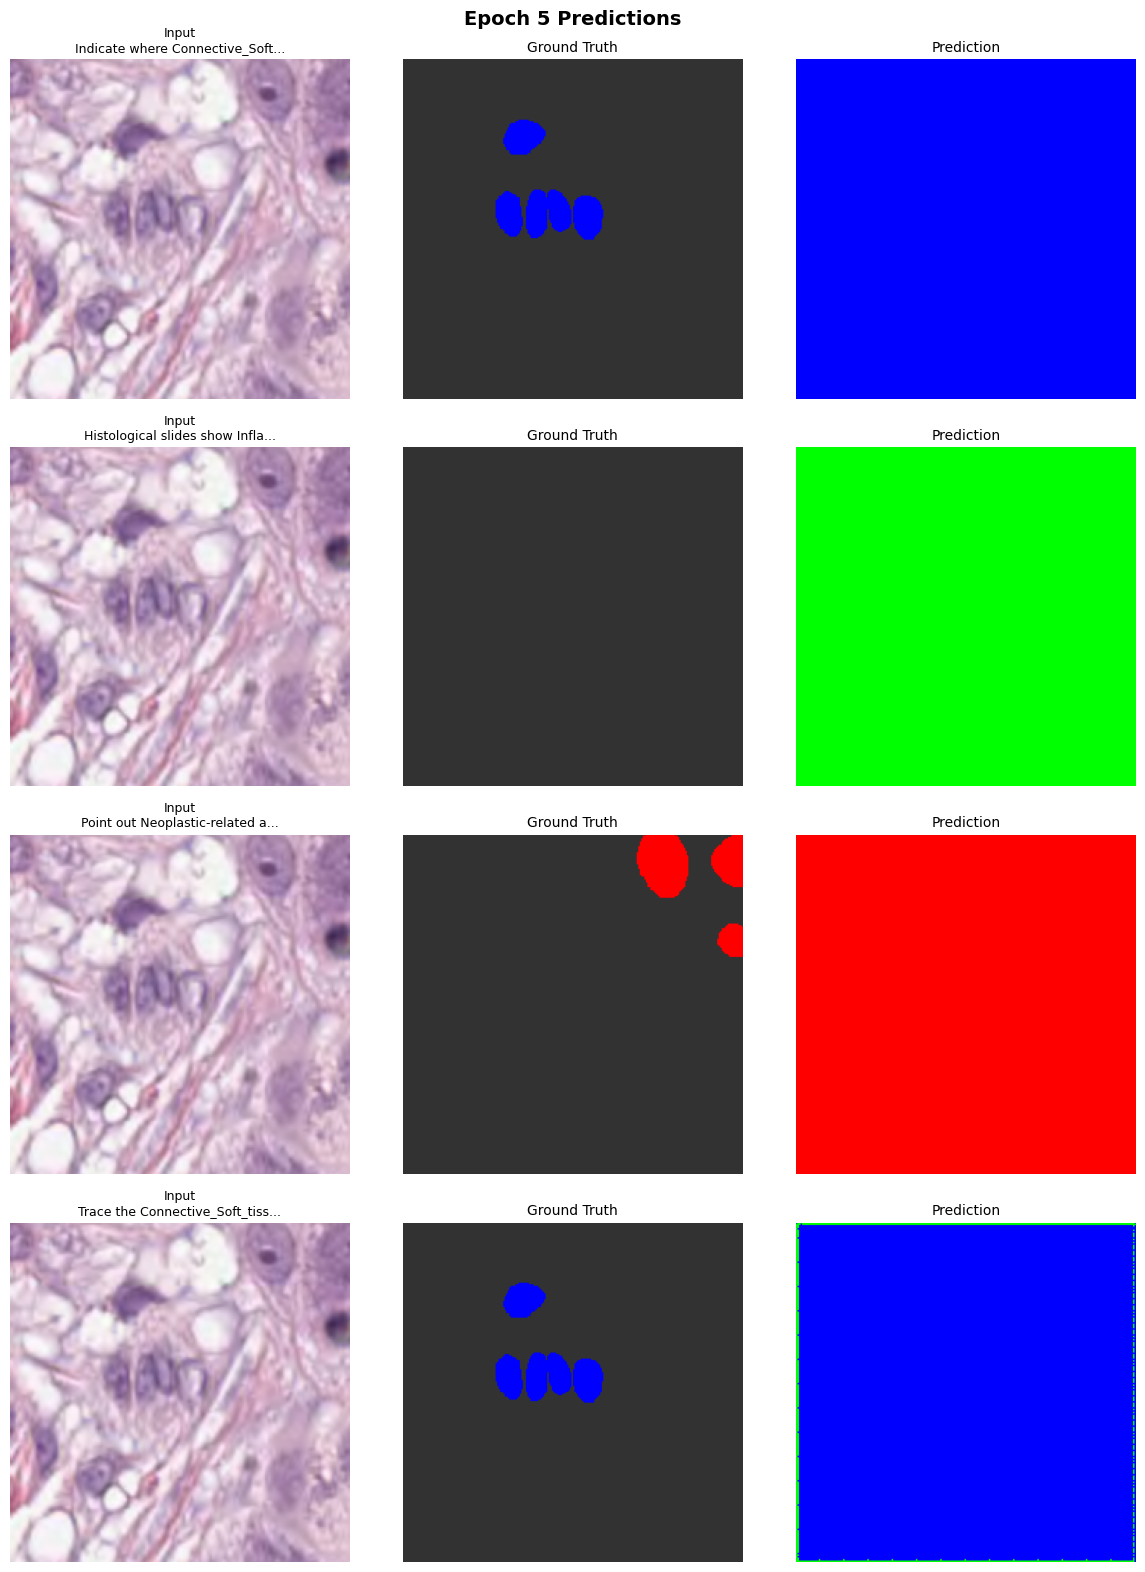

Training:   0%|          | 0/679 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 6/50 | LR: 1.00e-04
Train Loss: 1.4534 | Train Macro Dice: 0.4602
Val Loss:   1.5725 | Val Macro Dice:   0.5523
Val Mean IoU: 0.4741

Epoch 6 | Val Metrics
Dice:
  Neoplastic: 0.53
  Inflammatory: 0.49
  Connective_Soft_tissue: 0.49
  Epithelial: 0.54
  Dead: 0.71
Macro Dice: 0.55

No improvement. Patience: 4/10

No improvement. Patience: 4/10


Training:   0%|          | 0/679 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 7/50 | LR: 1.00e-04
Train Loss: 1.4373 | Train Macro Dice: 0.4669
Val Loss:   1.5589 | Val Macro Dice:   0.5210
Val Mean IoU: 0.4421

Epoch 7 | Val Metrics
Dice:
  Neoplastic: 0.42
  Inflammatory: 0.47
  Connective_Soft_tissue: 0.49
  Epithelial: 0.54
  Dead: 0.69
Macro Dice: 0.52

No improvement. Patience: 5/10

No improvement. Patience: 5/10


Training:   0%|          | 0/679 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 8/50 | LR: 5.00e-05
Train Loss: 1.4251 | Train Macro Dice: 0.4587
Val Loss:   1.6402 | Val Macro Dice:   0.5534
Val Mean IoU: 0.4748

Epoch 8 | Val Metrics
Dice:
  Neoplastic: 0.49
  Inflammatory: 0.49
  Connective_Soft_tissue: 0.47
  Epithelial: 0.55
  Dead: 0.76
Macro Dice: 0.55

No improvement. Patience: 6/10

No improvement. Patience: 6/10


Training:   0%|          | 0/679 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 9/50 | LR: 5.00e-05
Train Loss: 1.4556 | Train Macro Dice: 0.4778
Val Loss:   1.5404 | Val Macro Dice:   0.5407
Val Mean IoU: 0.4616

Epoch 9 | Val Metrics
Dice:
  Neoplastic: 0.49
  Inflammatory: 0.48
  Connective_Soft_tissue: 0.47
  Epithelial: 0.55
  Dead: 0.71
Macro Dice: 0.54

No improvement. Patience: 7/10

No improvement. Patience: 7/10


Training:   0%|          | 0/679 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 10/50 | LR: 5.00e-05
Train Loss: 1.4064 | Train Macro Dice: 0.4632
Val Loss:   1.5543 | Val Macro Dice:   0.5523
Val Mean IoU: 0.4741

Epoch 10 | Val Metrics
Dice:
  Neoplastic: 0.53
  Inflammatory: 0.49
  Connective_Soft_tissue: 0.49
  Epithelial: 0.54
  Dead: 0.71
Macro Dice: 0.55

No improvement. Patience: 8/10

📊 Generating visualization for epoch 10...

No improvement. Patience: 8/10

📊 Generating visualization for epoch 10...


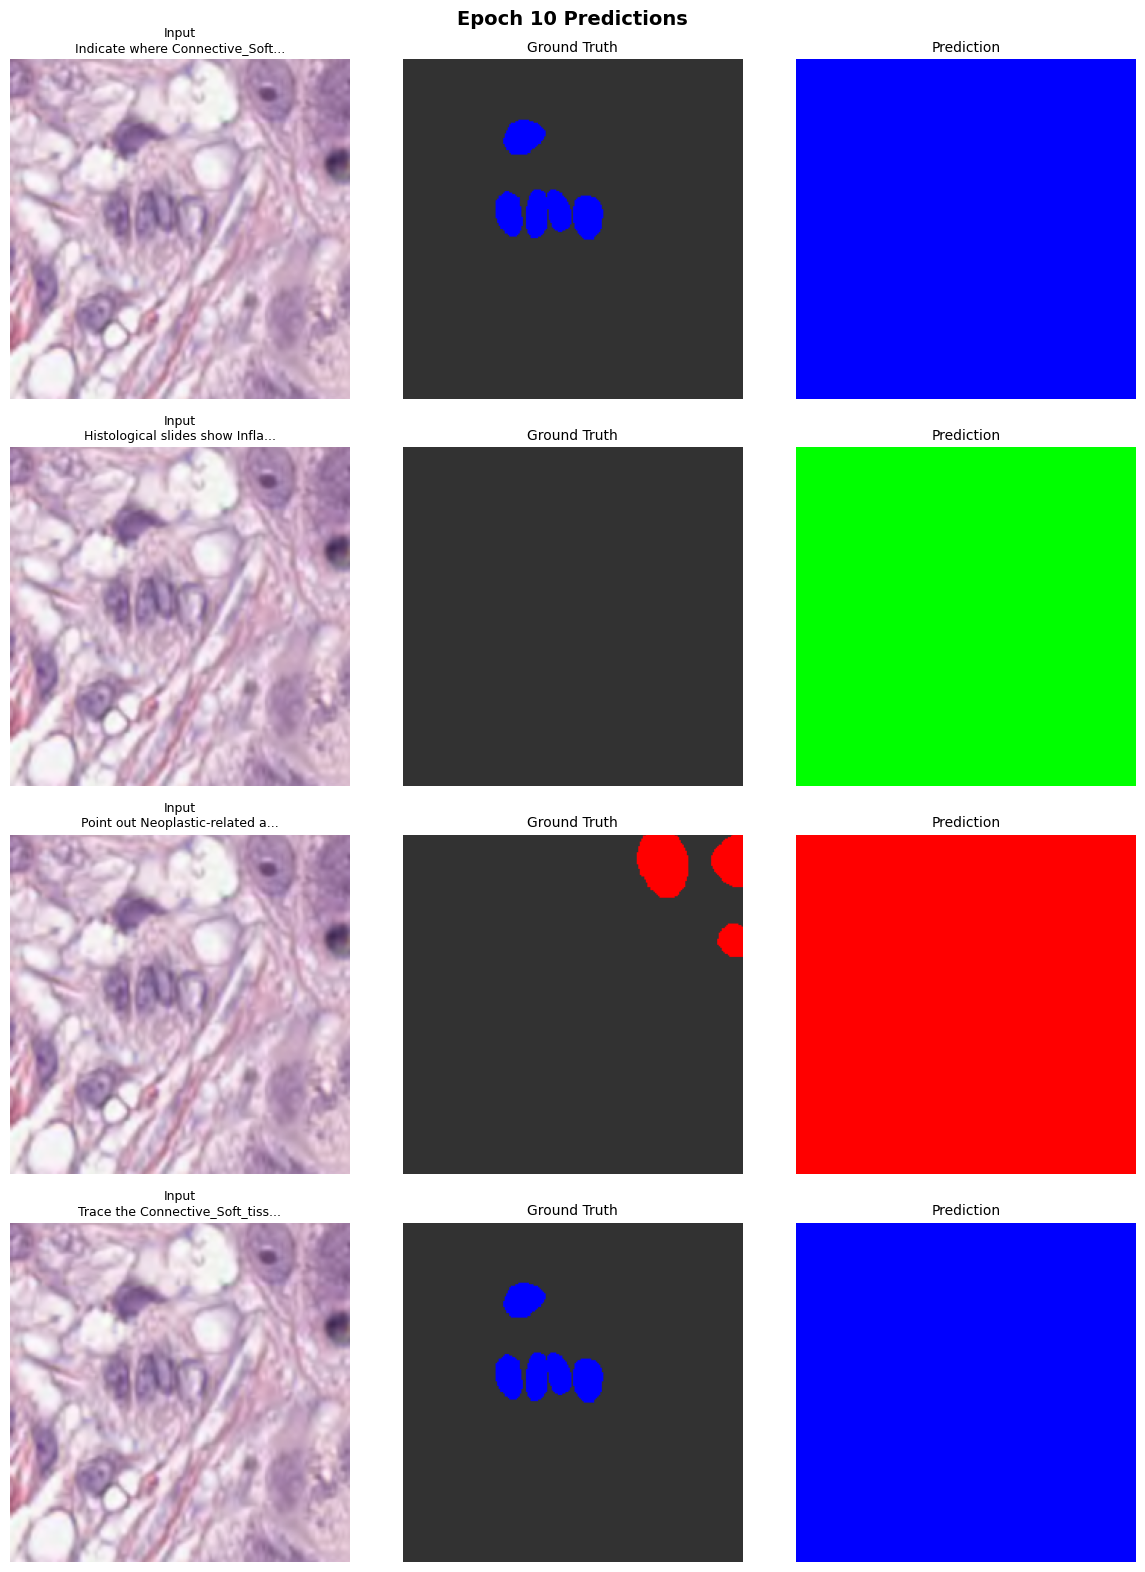

Training:   0%|          | 0/679 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 11/50 | LR: 5.00e-05
Train Loss: 1.4088 | Train Macro Dice: 0.4663
Val Loss:   1.5435 | Val Macro Dice:   0.5474
Val Mean IoU: 0.4693

Epoch 11 | Val Metrics
Dice:
  Neoplastic: 0.53
  Inflammatory: 0.47
  Connective_Soft_tissue: 0.49
  Epithelial: 0.54
  Dead: 0.71
Macro Dice: 0.55

No improvement. Patience: 9/10

No improvement. Patience: 9/10


Training:   0%|          | 0/679 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 12/50 | LR: 5.00e-05
Train Loss: 1.4033 | Train Macro Dice: 0.4661
Val Loss:   1.5395 | Val Macro Dice:   0.5189
Val Mean IoU: 0.4397

Epoch 12 | Val Metrics
Dice:
  Neoplastic: 0.49
  Inflammatory: 0.46
  Connective_Soft_tissue: 0.47
  Epithelial: 0.51
  Dead: 0.66
Macro Dice: 0.52

No improvement. Patience: 10/10

⚠️ Early stopping at epoch 12

Training Complete!
  Best Macro Dice: 0.5586
  Best model saved to: checkpoints/best_CIPS-Net_50.pth
  Last model saved to: checkpoints/last_CIPS-Net_50.pth

No improvement. Patience: 10/10

⚠️ Early stopping at epoch 12

Training Complete!
  Best Macro Dice: 0.5586
  Best model saved to: checkpoints/best_CIPS-Net_50.pth
  Last model saved to: checkpoints/last_CIPS-Net_50.pth


In [10]:
# Cell 10: Main Training Loop (Multi-Class Segmentation)
# ============================================================================
# TRAINING CONFIGURATION
# - Best model saved based on MACRO DICE (not loss)
# - Last epoch model always saved separately
# - Optional visualization every N epochs
# ============================================================================

best_macro_dice = 0.0
patience = 10
patience_counter = 0
visualize_every_n_epochs = 5  # Set to None to disable

# Checkpoint paths
BEST_MODEL_PATH = 'checkpoints/best_CIPS-Net_50.pth'
LAST_MODEL_PATH = 'checkpoints/last_CIPS-Net_50.pth'

# Ensure checkpoint directory exists
os.makedirs('checkpoints', exist_ok=True)

history = {
    'train_loss': [], 'val_loss': [],
    'train_macro_dice': [], 'val_macro_dice': [],
    'val_mean_iou': [],
}
# Per-class Dice history
for name in CLASS_NAMES:
    history[f'train_dice_{name}'] = []
    history[f'val_dice_{name}'] = []


def visualize_predictions(model, loader, device, epoch, num_samples=4):
    """Visualize predictions vs ground truth for qualitative monitoring."""
    model.eval()
    batch = next(iter(loader))
    images = batch['image'][:num_samples].to(device)
    masks = batch['mask'][:num_samples].to(device)
    instructions = batch['instruction'][:num_samples]
    
    with torch.no_grad():
        outputs = model(images, instructions)
        preds = torch.argmax(outputs['masks'], dim=1)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        # Denormalize image
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        gt = masks[i].cpu().numpy()
        pred = preds[i].cpu().numpy()
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Input\n{instructions[i][:30]}...', fontsize=9)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(colorize_mask(gt, ignore_index=IGNORE_INDEX))
        axes[i, 1].set_title('Ground Truth', fontsize=10)
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(colorize_mask(pred, ignore_index=IGNORE_INDEX))
        axes[i, 2].set_title('Prediction', fontsize=10)
        axes[i, 2].axis('off')
    
    plt.suptitle(f'Epoch {epoch} Predictions', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'checkpoints/viz_epoch_{epoch}.png', dpi=100, bbox_inches='tight')
    plt.show()
    plt.close()


print("=" * 80)
print("CIPS-Net MULTI-CLASS SEGMENTATION TRAINING")
print("=" * 80)
print(f"Training instances: {len(train_loader.dataset)}")
print(f"Validation instances: {len(val_loader.dataset)}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {CLASS_NAMES}")
print(f"Loss: CrossEntropy + DiceLoss (ignore_index={IGNORE_INDEX})")
print(f"Model selection: Best Macro Dice")
print(f"Visualization: Every {visualize_every_n_epochs} epochs")
print("=" * 80 + "\n")

for epoch in range(num_epochs):
    # Training
    train_loss, train_dice_per_class, train_macro_dice = train_epoch(
        model, train_loader, criterion, optimizer, device, NUM_CLASSES, ignore_index=IGNORE_INDEX
    )
    
    # Validation
    val_loss, val_dice_per_class, val_macro_dice, val_iou_per_class, val_mean_iou = validate_epoch(
        model, val_loader, criterion, device, NUM_CLASSES, ignore_index=IGNORE_INDEX
    )
    
    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_macro_dice'].append(train_macro_dice)
    history['val_macro_dice'].append(val_macro_dice)
    history['val_mean_iou'].append(val_mean_iou)
    
    for i, name in enumerate(CLASS_NAMES):
        history[f'train_dice_{name}'].append(train_dice_per_class[i])
        history[f'val_dice_{name}'].append(val_dice_per_class[i])
    
    # Scheduler step (based on validation macro dice)
    scheduler.step(val_macro_dice)
    current_lr = optimizer.param_groups[0]['lr']
    
    # ========================================================================
    # CLEAR, READABLE METRIC LOGGING (Per-Class Dice)
    # ========================================================================
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{num_epochs} | LR: {current_lr:.2e}")
    print(f"{'='*60}")
    print(f"Train Loss: {train_loss:.4f} | Train Macro Dice: {train_macro_dice:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Macro Dice:   {val_macro_dice:.4f}")
    print(f"Val Mean IoU: {val_mean_iou:.4f}")
    print(f"\nEpoch {epoch+1} | Val Metrics")
    print("Dice:")
    for i, name in enumerate(CLASS_NAMES):
        print(f"  {name}: {val_dice_per_class[i]:.2f}")
    print(f"Macro Dice: {val_macro_dice:.2f}")
    
    # ========================================================================
    # MODEL CHECKPOINTING (Based on Macro Dice, NOT loss)
    # ========================================================================
    
    # Always save last model
    last_checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'macro_dice': val_macro_dice,
        'val_dice_per_class': val_dice_per_class,
        'class_names': CLASS_NAMES,
        'num_classes': NUM_CLASSES,
        'ignore_index': IGNORE_INDEX,
    }
    torch.save(last_checkpoint, LAST_MODEL_PATH)
    
    # Save best model (based on Macro Dice)
    if val_macro_dice > best_macro_dice:
        best_macro_dice = val_macro_dice
        patience_counter = 0
        
        best_checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_macro_dice': best_macro_dice,
            'val_dice_per_class': val_dice_per_class,
            'class_names': CLASS_NAMES,
            'num_classes': NUM_CLASSES,
            'ignore_index': IGNORE_INDEX,
            'history': history
        }
        torch.save(best_checkpoint, BEST_MODEL_PATH)
        print(f"\n*** New Best Model! Macro Dice: {best_macro_dice:.4f} → Saved to {BEST_MODEL_PATH} ***")
    else:
        patience_counter += 1
        print(f"\nNo improvement. Patience: {patience_counter}/{patience}")
    
    # ========================================================================
    # OPTIONAL VISUALIZATION (Every N epochs)
    # ========================================================================
    if visualize_every_n_epochs and (epoch + 1) % visualize_every_n_epochs == 0:
        print(f"\n📊 Generating visualization for epoch {epoch+1}...")
        visualize_predictions(model, val_loader, device, epoch + 1, num_samples=4)
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\n⚠️ Early stopping at epoch {epoch+1}")
        break

print("\n" + "=" * 80)
print(f"Training Complete!")
print(f"  Best Macro Dice: {best_macro_dice:.4f}")
print(f"  Best model saved to: {BEST_MODEL_PATH}")
print(f"  Last model saved to: {LAST_MODEL_PATH}")
print("=" * 80)

## 8. Training History Visualization

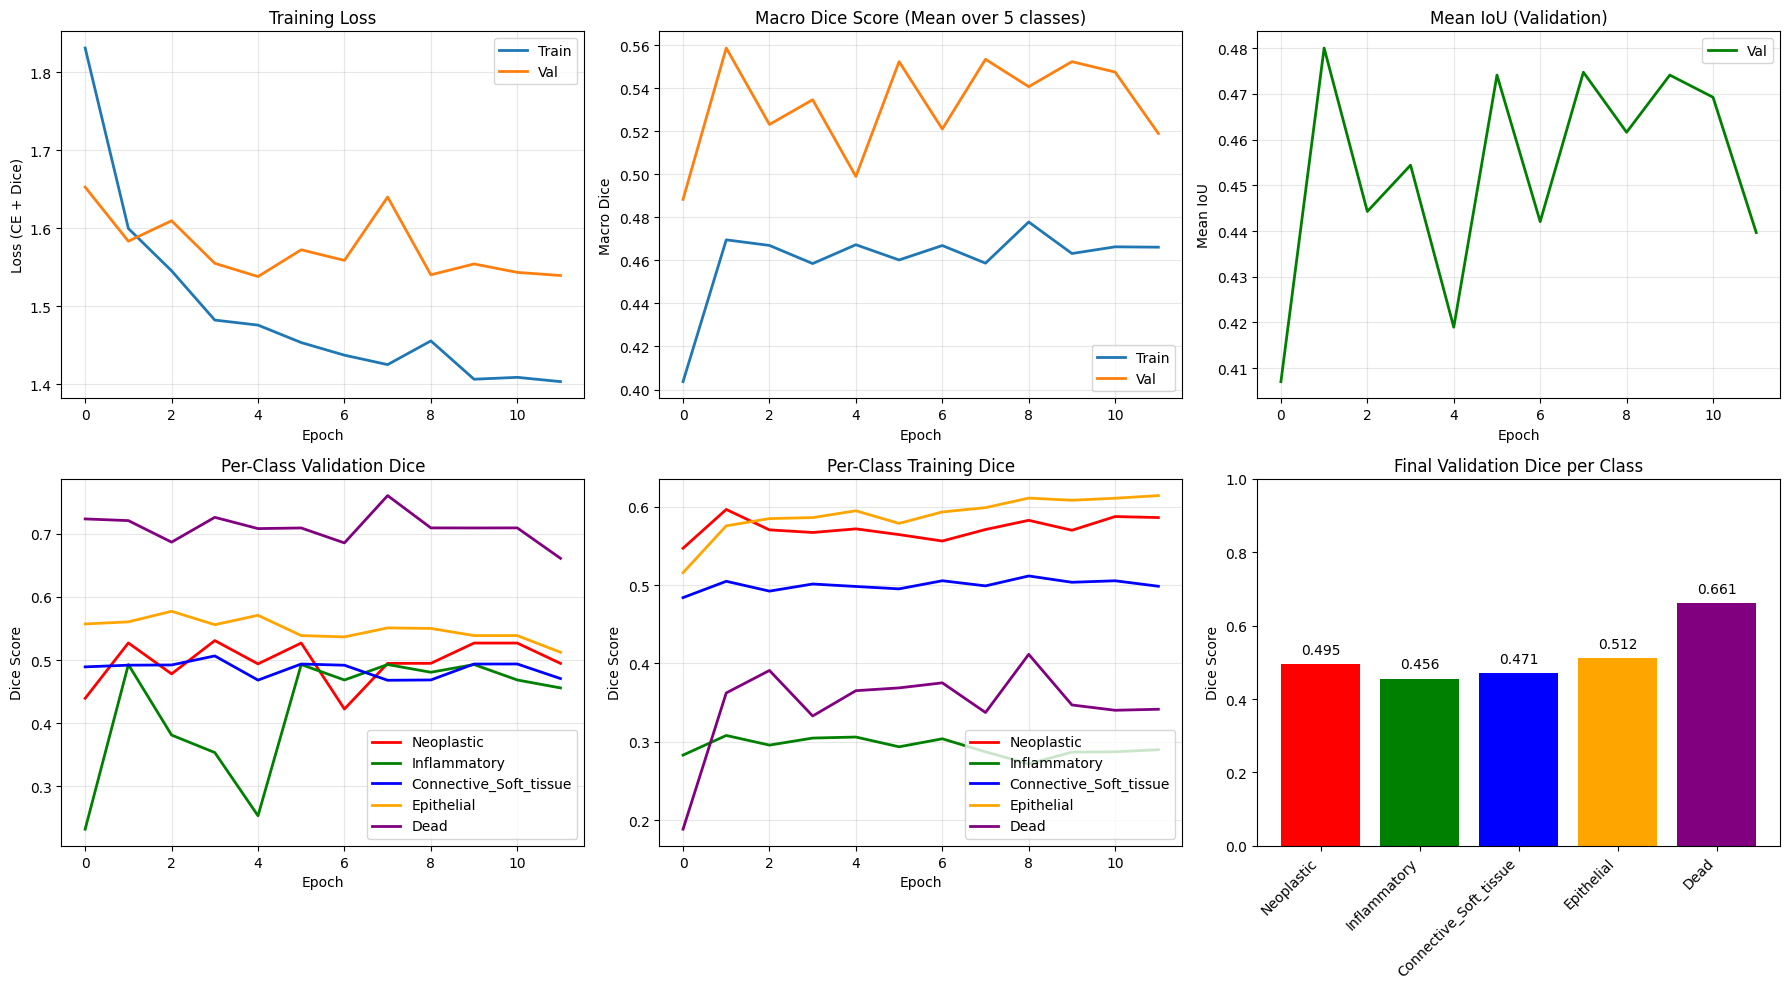


Best Validation Macro Dice: 0.5586 at epoch 2


In [11]:
# Cell 11: Plot Training History (Multi-Class)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Loss, Macro Dice, Mean IoU
axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (CE + Dice)')
axes[0, 0].set_title('Training Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history['train_macro_dice'], label='Train', linewidth=2)
axes[0, 1].plot(history['val_macro_dice'], label='Val', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Macro Dice')
axes[0, 1].set_title('Macro Dice Score (Mean over 5 classes)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].plot(history['val_mean_iou'], label='Val', linewidth=2, color='green')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Mean IoU')
axes[0, 2].set_title('Mean IoU (Validation)')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Row 2: Per-class Validation Dice
colors = ['red', 'green', 'blue', 'orange', 'purple']
for i, name in enumerate(CLASS_NAMES):
    axes[1, 0].plot(history[f'val_dice_{name}'], label=name, linewidth=2, color=colors[i])
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Dice Score')
axes[1, 0].set_title('Per-Class Validation Dice')
axes[1, 0].legend(loc='lower right')
axes[1, 0].grid(True, alpha=0.3)

# Per-class Train Dice
for i, name in enumerate(CLASS_NAMES):
    axes[1, 1].plot(history[f'train_dice_{name}'], label=name, linewidth=2, color=colors[i])
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Dice Score')
axes[1, 1].set_title('Per-Class Training Dice')
axes[1, 1].legend(loc='lower right')
axes[1, 1].grid(True, alpha=0.3)

# Final per-class Dice bar chart
final_val_dice = [history[f'val_dice_{name}'][-1] for name in CLASS_NAMES]
bars = axes[1, 2].bar(CLASS_NAMES, final_val_dice, color=colors)
axes[1, 2].set_ylabel('Dice Score')
axes[1, 2].set_title('Final Validation Dice per Class')
axes[1, 2].set_ylim(0, 1)
for bar, dice in zip(bars, final_val_dice):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                     f'{dice:.3f}', ha='center', va='bottom', fontsize=10)
plt.setp(axes[1, 2].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('multiclass_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nBest Validation Macro Dice: {max(history['val_macro_dice']):.4f} at epoch {np.argmax(history['val_macro_dice'])+1}")

## 9. Load Best Model and Visualize Multi-Class Predictions

Visualization using fixed color maps:
- **Red**: Neoplastic (class 0)
- **Green**: Inflammatory (class 1)
- **Blue**: Connective_Soft_tissue (class 2)
- **Yellow**: Epithelial (class 3)
- **Magenta**: Dead (class 4)

In [14]:
# Cell 12: Load Best Model for Visualization
# NOTE (PyTorch 2.6+): torch.load defaults to weights_only=True, which uses a restricted unpickler.
# If you trust this checkpoint file, this cell will try a safe allowlist first, then fall back to
# weights_only=False (which can execute arbitrary code from the checkpoint).
checkpoint_path = 'checkpoints/best_model.pth'

safe_globals = [
    np.core.multiarray.scalar,  # fixes: "Unsupported global: numpy.core.multiarray.scalar"
    np.dtype,                   # commonly needed for numpy objects in checkpoints
]

try:
    with torch.serialization.safe_globals(safe_globals):
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)
except Exception as e:
    print(f"Safe weights-only load failed ({type(e).__name__}: {e})")
    print("Falling back to weights_only=False (ONLY do this if you trust the checkpoint source).")
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("=" * 70)
print("LOADED BEST MODEL FOR VISUALIZATION")
print("=" * 70)
print(f"  Epoch: {checkpoint['epoch']}")
print(f"  Best Macro Dice: {checkpoint['best_macro_dice']:.4f}")
print(f"  Per-class Dice at best epoch:")
for i, name in enumerate(CLASS_NAMES):
    print(f"    {name:25s}: {checkpoint['val_dice_per_class'][i]:.4f}")
print("=" * 70)

print("✓ Model loaded and ready for visualization")

Safe weights-only load failed (UnpicklingError: Weights only load failed. In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
Please file an issue with the following so that we can make `weights_only=True` compatible with your use case: WeightsUnpickler error: 

Can only build Tensor, Parameter, OrderedDict or types allowlisted via `add_safe_globals`, but got <class 'numpy.dtypes.Float64DType'>

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.)
Falling back to weights_only=False (ONLY do this if you trust the checkpoint source).
LOADED BEST MODEL FOR VISUALIZATION
  Epoch: 3
  Best Macro Dice: 0.7950
  Per-class Dice at best epoch:
   

In [15]:
# Cell 13: Clean Visualization - Original | Ground Truth | Prediction (Masked)
def visualize_samples(model, dataset, num_samples=5, device='cuda', save_path='predictions_visualization.png'):
    """
    Visualize random samples showing:
    - Left: Original image with class names present in title
    - Middle: Ground truth mask (colorized)
    - Right: Predicted mask (colorized) - ONLY where GT is valid (not ignored)
    
    IMPORTANT: We mask predictions to only show where GT has valid labels.
    This allows fair comparison since model was trained with ignore_index=255.
    The model has no "background" class, so it must predict 0-4 for all pixels.
    
    Tries to cover all classes across the selected samples.
    """
    model.eval()
    
    # Strategy: Select samples that collectively cover all classes
    class_to_samples = {i: [] for i in range(NUM_CLASSES)}
    
    for idx in range(len(dataset)):
        sample = dataset[idx]
        mask = sample['mask'].numpy()
        valid_mask = mask != IGNORE_INDEX
        if valid_mask.sum() > 0:
            unique_classes = np.unique(mask[valid_mask]).astype(int)
            for c in unique_classes:
                if c < NUM_CLASSES:
                    class_to_samples[c].append(idx)
    
    # Select samples to maximize class coverage
    selected_indices = []
    classes_covered = set()
    
    for class_idx in range(NUM_CLASSES):
        if class_idx not in classes_covered and class_to_samples[class_idx]:
            candidates = [idx for idx in class_to_samples[class_idx] if idx not in selected_indices]
            if candidates:
                chosen = np.random.choice(candidates)
                selected_indices.append(chosen)
                sample = dataset[chosen]
                mask = sample['mask'].numpy()
                valid_mask = mask != IGNORE_INDEX
                if valid_mask.sum() > 0:
                    for c in np.unique(mask[valid_mask]).astype(int):
                        if c < NUM_CLASSES:
                            classes_covered.add(c)
    
    # Fill remaining slots
    all_indices = list(range(len(dataset)))
    remaining = [i for i in all_indices if i not in selected_indices]
    while len(selected_indices) < num_samples and remaining:
        chosen = np.random.choice(remaining)
        selected_indices.append(chosen)
        remaining.remove(chosen)
    
    selected_indices = selected_indices[:num_samples]
    
    print(f"Selected {len(selected_indices)} samples covering classes: {sorted(classes_covered)}")
    print(f"Classes covered: {[CLASS_NAMES[c] for c in sorted(classes_covered)]}")
    
    # Create figure: num_samples rows x 3 columns
    fig, axes = plt.subplots(len(selected_indices), 3, figsize=(12, 4 * len(selected_indices)))
    
    if len(selected_indices) == 1:
        axes = axes.reshape(1, -1)
    
    total_correct = 0
    total_pixels = 0
    
    with torch.no_grad():
        for row_idx, sample_idx in enumerate(selected_indices):
            sample = dataset[sample_idx]
            
            image = sample['image'].unsqueeze(0).to(device)
            gt_mask = sample['mask'].numpy()
            text_query = sample['instruction']
            
            # Get prediction
            output = model(image, [text_query])
            logits = output['masks']
            pred_mask_full = torch.argmax(logits, dim=1)[0].cpu().numpy()
            
            # CRITICAL: Create masked prediction - only show where GT is valid
            valid_region = gt_mask != IGNORE_INDEX
            pred_mask_masked = np.full_like(gt_mask, IGNORE_INDEX)  # Start with all ignored
            pred_mask_masked[valid_region] = pred_mask_full[valid_region]  # Copy only valid regions
            
            # Calculate accuracy on valid region
            if valid_region.sum() > 0:
                correct = (pred_mask_full[valid_region] == gt_mask[valid_region]).sum()
                total = valid_region.sum()
                acc = correct / total * 100
                total_correct += correct
                total_pixels += total
            else:
                acc = 0
            
            # Denormalize image
            img_np = sample['image'].permute(1, 2, 0).numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_display = np.clip(img_np * std + mean, 0, 1)
            
            # Get classes in GT
            valid_gt = gt_mask[valid_region]
            gt_classes = np.unique(valid_gt).astype(int) if len(valid_gt) > 0 else []
            gt_class_names = [CLASS_NAMES[c] for c in gt_classes if c < NUM_CLASSES]
            
            # Get classes in prediction (only valid region)
            valid_pred = pred_mask_full[valid_region]
            pred_classes = np.unique(valid_pred).astype(int) if len(valid_pred) > 0 else []
            pred_class_names = [CLASS_NAMES[c] for c in pred_classes if c < NUM_CLASSES]
            
            # Colorize masks
            gt_rgb = colorize_mask(gt_mask)
            pred_rgb = colorize_mask(pred_mask_masked)  # Use masked prediction
            
            # Column 0: Original image
            axes[row_idx, 0].imshow(img_display)
            title_classes = ', '.join(gt_class_names) if gt_class_names else 'No classes'
            axes[row_idx, 0].set_title(f'Original\nGT Classes: {title_classes}', fontsize=10, fontweight='bold')
            axes[row_idx, 0].axis('off')
            
            # Column 1: Ground Truth
            axes[row_idx, 1].imshow(gt_rgb)
            axes[row_idx, 1].set_title(f'Ground Truth', fontsize=10, fontweight='bold')
            axes[row_idx, 1].axis('off')
            
            # Column 2: Prediction (masked to valid region only)
            axes[row_idx, 2].imshow(pred_rgb)
            pred_title = ', '.join(pred_class_names) if pred_class_names else 'No classes'
            axes[row_idx, 2].set_title(f'Prediction (Acc: {acc:.1f}%)\n({pred_title})', fontsize=10)
            axes[row_idx, 2].axis('off')
    
    # Overall accuracy
    overall_acc = total_correct / total_pixels * 100 if total_pixels > 0 else 0
    
    # Add legend
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=np.array(CLASS_COLORS[i])/255.0, 
                                       edgecolor='black', label=f'{i}: {CLASS_NAMES[i]}') 
                       for i in range(NUM_CLASSES)]
    legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=np.array(IGNORED_COLOR)/255.0, 
                                          edgecolor='black', label='Ignored/Background'))
    
    fig.legend(handles=legend_elements, loc='lower center', ncol=NUM_CLASSES+1, 
               fontsize=9, frameon=True, bbox_to_anchor=(0.5, -0.02))
    
    plt.suptitle(f'Multi-Class Segmentation (Overall Pixel Accuracy: {overall_acc:.1f}%)\n'
                 f'Prediction shown ONLY on valid GT regions (background masked)', 
                 fontsize=12, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Visualization saved to '{save_path}'")
    print(f"✓ Overall pixel accuracy on valid regions: {overall_acc:.2f}%")
    print("\nNOTE: Predictions are masked to only show valid GT regions.")
    print("      The model has no 'background' class - it must predict 0-4 for all pixels.")
    print("      Dark gray = ignored/background (IGNORE_INDEX=255)")

print("✓ Clean visualization function defined (with masked predictions)!")

✓ Clean visualization function defined (with masked predictions)!


Visualizing 5 random samples (covering all classes)
Selected 5 samples covering classes: [0, 1, 2, 3, 4]
Classes covered: ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Epithelial', 'Dead']


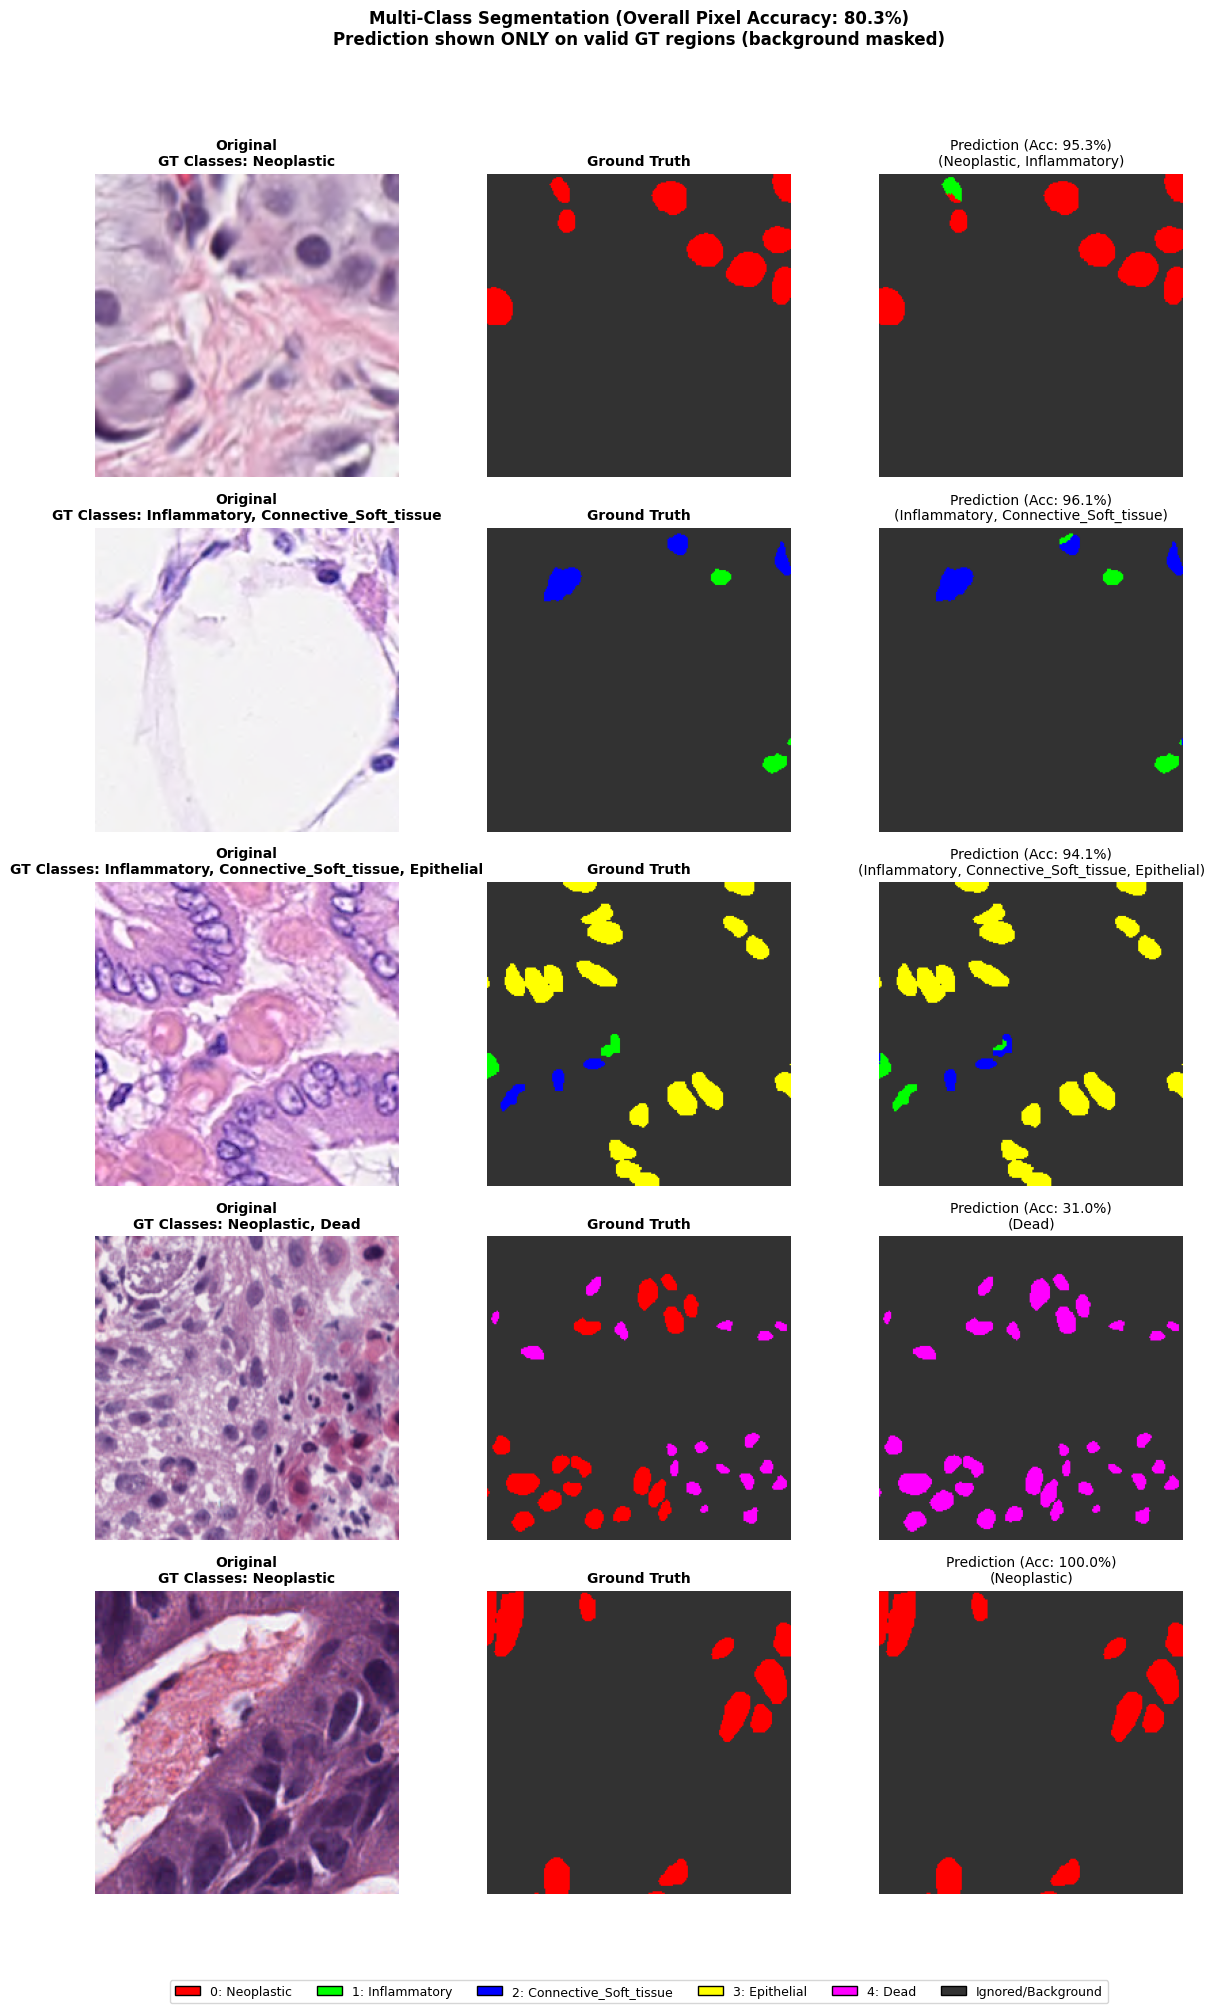


✓ Visualization saved to 'validation_predictions.png'
✓ Overall pixel accuracy on valid regions: 80.35%

NOTE: Predictions are masked to only show valid GT regions.
      The model has no 'background' class - it must predict 0-4 for all pixels.
      Dark gray = ignored/background (IGNORE_INDEX=255)


In [16]:
# Cell 14: Visualize 5 Random Samples from Validation Set
print("=" * 60)
print("Visualizing 5 random samples (covering all classes)")
print("=" * 60)

# Set random seed for reproducibility (optional - remove for truly random)
np.random.seed(42)

# Visualize on validation set
visualize_samples(
    model=model, 
    dataset=val_dataset, 
    num_samples=5, 
    device=device,
    save_path='validation_predictions.png'
)

## Multi-Query Visualization: Single Image with Different Text Queries

This visualization shows how the model responds to **different text queries** on the **same image**. 
For a single image containing multiple tissue classes, we show:
- The original image
- For each class query: Ground Truth mask vs Model Prediction
- This demonstrates the model's text-conditional segmentation capability

In [21]:
# Cell: Multi-Query Visualization - Different Text Queries on Same Image
# Uses ACTUAL CAPTIONS from the dataset for each class/combination

def visualize_multi_query_single_image(model, image_path, dataframe, mask_dir='Dataset/multi_masks',
                                        img_dir='Dataset/multi_images', device='cuda',
                                        img_size=224, save_path='multi_query_visualization.png'):
    """
    Visualize how the model responds to different text queries on the SAME image.
    Uses the ACTUAL CAPTIONS from the dataset!
    
    For a single image, this function:
    1. Finds all rows in the dataframe for this image (different class combinations)
    2. For each row, uses the ACTUAL instruction from the dataset
    3. Shows ground truth mask and model prediction side by side
    
    This demonstrates the text-conditional nature of the model.
    
    Args:
        model: Trained CIPS-Net model
        image_path: Name of the image file (e.g., 'image_001_img.png')
        dataframe: The dataset dataframe containing 'instruction' column
        mask_dir: Directory containing mask files
        img_dir: Directory containing image files
        device: 'cuda' or 'cpu'
        img_size: Size to resize images to
        save_path: Path to save the visualization
    """
    model.eval()
    
    # Get base name for mask paths
    base_name = image_path.replace('_img.png', '')
    full_img_path = os.path.join(img_dir, image_path)
    
    # Load and preprocess image
    image = cv2.imread(full_img_path)
    if image is None:
        print(f"Error: Image not found at {full_img_path}")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image.copy()
    
    # Resize image
    image = cv2.resize(image, (img_size, img_size))
    
    # Normalize for model input
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_normalized = (image.astype(np.float32) / 255.0 - mean) / std
    image_tensor = torch.from_numpy(image_normalized).permute(2, 0, 1).float().unsqueeze(0).to(device)
    
    # Load all class masks for this image
    class_masks = {}
    for class_name in CLASS_NAMES:
        channel_idx = CHANNEL_MAPPING[class_name]
        mask_filename = f"{base_name}_channel_{channel_idx}_{class_name}.png"
        mask_path = os.path.join(mask_dir, mask_filename)
        
        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST)
            mask_binary = (mask > 127)
            if mask_binary.sum() > 0:
                class_masks[class_name] = mask_binary
    
    if not class_masks:
        print(f"No class masks found for image: {image_path}")
        return
    
    # Get all rows from dataframe for this image (each row has different class combination)
    image_rows = dataframe[dataframe['image_path'] == image_path].copy()
    
    if len(image_rows) == 0:
        print(f"No entries found in dataframe for image: {image_path}")
        return
    
    print(f"Image: {image_path}")
    print(f"Available class masks: {list(class_masks.keys())}")
    print(f"Found {len(image_rows)} different queries in dataset for this image")
    
    # Build queries from dataset - use ACTUAL instructions
    queries = []
    for _, row in image_rows.iterrows():
        classes_str = str(row['classes'])
        query_classes = [c.strip() for c in classes_str.split(';') if c.strip() in CLASS_NAMES]
        
        # Only include if we have masks for these classes
        valid_classes = [c for c in query_classes if c in class_masks]
        if not valid_classes:
            continue
            
        queries.append({
            'instruction': row['instruction'],  # ACTUAL caption from dataset
            'classes': valid_classes,
            'classes_str': classes_str,
            'label': row.get('classes_clean', classes_str)
        })
    
    if not queries:
        print("No valid queries found with available masks")
        return
    
    # Limit to avoid too large figures (show diverse samples)
    if len(queries) > 6:
        # Keep first single-class queries and some multi-class ones
        single_class = [q for q in queries if len(q['classes']) == 1]
        multi_class = [q for q in queries if len(q['classes']) > 1]
        queries = single_class[:4] + multi_class[:2]
    
    print(f"\nDisplaying {len(queries)} queries:")
    for i, q in enumerate(queries):
        print(f"  {i+1}. Classes: {q['classes_str']}")
        print(f"     Caption: \"{q['instruction'][:70]}...\"" if len(q['instruction']) > 70 else f"     Caption: \"{q['instruction']}\"")
    
    # Create figure
    num_queries = len(queries)
    fig, axes = plt.subplots(num_queries, 3, figsize=(15, 5 * num_queries))
    
    if num_queries == 1:
        axes = axes.reshape(1, -1)
    
    # Image for display
    img_display = cv2.resize(original_image, (img_size, img_size))
    img_display = img_display.astype(np.float32) / 255.0
    
    with torch.no_grad():
        for row_idx, query_info in enumerate(queries):
            instruction = query_info['instruction']  # ACTUAL caption
            query_classes = query_info['classes']
            query_label = query_info['label']
            
            # Create ground truth mask for this query
            gt_mask = np.full((img_size, img_size), IGNORE_INDEX, dtype=np.int64)
            for class_name in query_classes:
                if class_name in class_masks:
                    class_idx = CLASS_TO_IDX[class_name]
                    gt_mask[class_masks[class_name]] = class_idx
            
            # Get model prediction using ACTUAL caption
            output = model(image_tensor, [instruction])
            logits = output['masks']
            pred_mask_full = torch.argmax(logits, dim=1)[0].cpu().numpy()
            
            # Mask prediction to valid regions
            valid_region = gt_mask != IGNORE_INDEX
            pred_mask_masked = np.full_like(gt_mask, IGNORE_INDEX)
            pred_mask_masked[valid_region] = pred_mask_full[valid_region]
            
            # Calculate accuracy
            if valid_region.sum() > 0:
                correct = (pred_mask_full[valid_region] == gt_mask[valid_region]).sum()
                acc = correct / valid_region.sum() * 100
            else:
                acc = 0
            
            # Colorize masks
            gt_rgb = colorize_mask(gt_mask)
            pred_rgb = colorize_mask(pred_mask_masked)
            
            # Column 0: Original image with query
            axes[row_idx, 0].imshow(img_display)
            axes[row_idx, 0].set_title(f'Original Image\nQuery: "{query_label}"', fontsize=11, fontweight='bold')
            axes[row_idx, 0].axis('off')
            
            # Add text box with ACTUAL instruction from dataset
            instr_short = instruction[:70] + '...' if len(instruction) > 70 else instruction
            axes[row_idx, 0].text(0.5, -0.05, f'"{instr_short}"', transform=axes[row_idx, 0].transAxes,
                                   fontsize=8, ha='center', style='italic',
                                   bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
            
            # Column 1: Ground Truth
            axes[row_idx, 1].imshow(gt_rgb)
            gt_class_names = [CLASS_NAMES[c] for c in np.unique(gt_mask[valid_region]).astype(int) if c < NUM_CLASSES]
            axes[row_idx, 1].set_title(f'Ground Truth\nClasses: {", ".join(gt_class_names)}', fontsize=10, fontweight='bold')
            axes[row_idx, 1].axis('off')
            
            # Column 2: Prediction
            axes[row_idx, 2].imshow(pred_rgb)
            pred_classes_in_valid = [CLASS_NAMES[c] for c in np.unique(pred_mask_masked[valid_region]).astype(int) if c < NUM_CLASSES]
            axes[row_idx, 2].set_title(f'Prediction (Acc: {acc:.1f}%)\nPredicted: {", ".join(pred_classes_in_valid)}', 
                                        fontsize=10)
            axes[row_idx, 2].axis('off')
    
    # Add legend
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=np.array(CLASS_COLORS[i])/255.0, 
                                       edgecolor='black', label=f'{CLASS_NAMES[i]}') 
                       for i in range(NUM_CLASSES)]
    legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=np.array(IGNORED_COLOR)/255.0, 
                                          edgecolor='black', label='Ignored/Background'))
    
    fig.legend(handles=legend_elements, loc='lower center', ncol=NUM_CLASSES+1, 
               fontsize=9, frameon=True, bbox_to_anchor=(0.5, -0.02))
    
    plt.suptitle(f'Multi-Query Visualization: Different Text Queries on Same Image\n'
                 f'Image: {image_path} | Using ACTUAL captions from dataset', 
                 fontsize=13, fontweight='bold')
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Visualization saved to '{save_path}'")


def find_image_with_multiple_classes(df, min_classes=3):
    """
    Find an image that contains at least min_classes different tissue types.
    """
    # Get unique images
    unique_images = df['image_path'].unique()
    
    for img_path in unique_images:
        # Get all class combinations for this image
        img_rows = df[df['image_path'] == img_path]
        all_classes = set()
        for classes_str in img_rows['classes'].values:
            for c in str(classes_str).split(';'):
                c = c.strip()
                if c in CLASS_NAMES:
                    all_classes.add(c)
        
        if len(all_classes) >= min_classes:
            return img_path, list(all_classes)
    
    # Fallback: return first image
    return unique_images[0], []


print("✓ Multi-query visualization function defined!")
print("\nThis function will show how the model responds to different text queries on the same image.")
print("For each class present in the image, it will display GT vs Prediction.")

✓ Multi-query visualization function defined!

This function will show how the model responds to different text queries on the same image.
For each class present in the image, it will display GT vs Prediction.


MULTI-QUERY VISUALIZATION: Different Text Queries on Same Image
Using ACTUAL CAPTIONS from the dataset!

Selected image: 1_Breast_fold_1_0029_img.png
Classes available: ['Inflammatory', 'Connective_Soft_tissue', 'Neoplastic']
Image: 1_Breast_fold_1_0029_img.png
Available class masks: ['Neoplastic', 'Connective_Soft_tissue']
Found 7 different queries in dataset for this image

Displaying 6 queries:
  1. Classes: Connective_Soft_tissue
     Caption: "Indicate where Connective_Soft_tissue alters normal histology of Breas..."
  2. Classes: Neoplastic
     Caption: "Point out Neoplastic-related abnormalities in the Breast tissue."
  3. Classes: Connective_Soft_tissue;Inflammatory
     Caption: "Trace the Connective_Soft_tissue and Inflammatory visible across the B..."
  4. Classes: Connective_Soft_tissue;Neoplastic
     Caption: "This Breast belongs to which class? Options: Connective_Soft_tissue an..."
  5. Classes: Inflammatory;Neoplastic
     Caption: "Trace borders of the lesion within 

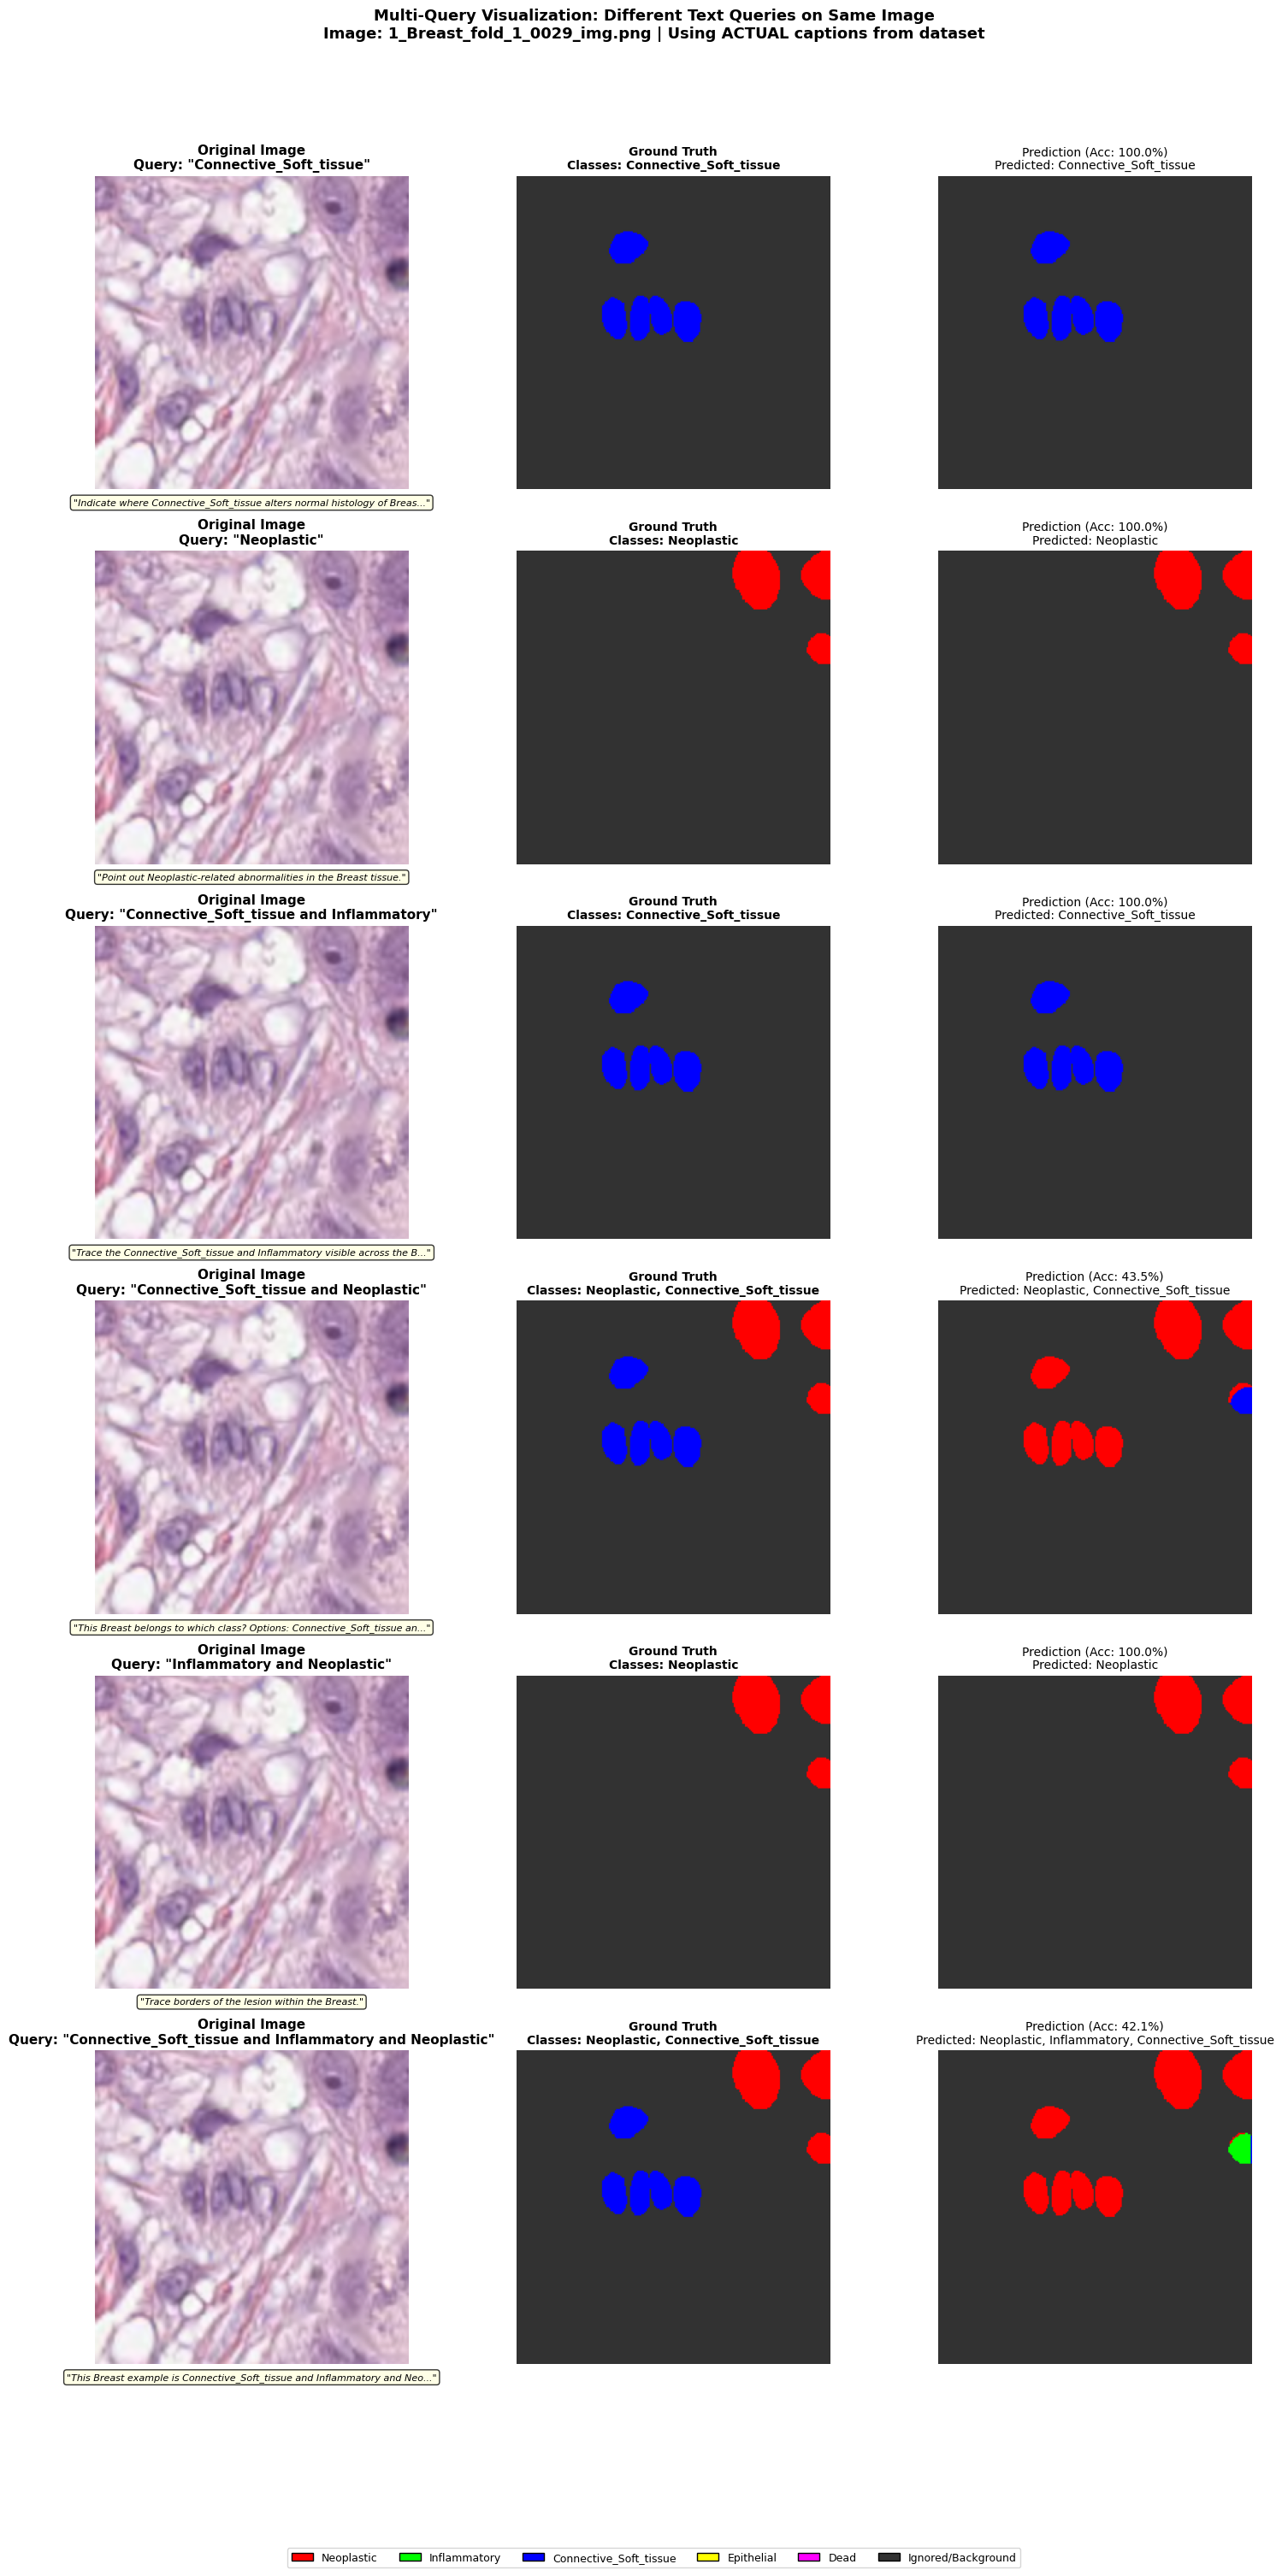


✓ Visualization saved to 'multi_query_single_image2.png'

This shows how the model segments DIFFERENT regions based on the text query!
Captions are from the ACTUAL dataset, not generated!


In [22]:
# Cell: Run Multi-Query Visualization (Using ACTUAL captions from dataset)
print("=" * 70)
print("MULTI-QUERY VISUALIZATION: Different Text Queries on Same Image")
print("Using ACTUAL CAPTIONS from the dataset!")
print("=" * 70)

# Find an image with multiple classes
best_image, available_classes = find_image_with_multiple_classes(val_df, min_classes=3)
print(f"\nSelected image: {best_image}")
print(f"Classes available: {available_classes}")

# If no image found with 3+ classes, try with 2
if len(available_classes) < 2:
    best_image, available_classes = find_image_with_multiple_classes(val_df, min_classes=2)
    print(f"\nFallback image: {best_image}")
    print(f"Classes available: {available_classes}")

# Visualize using ACTUAL captions from the dataset
visualize_multi_query_single_image(
    model=model,
    image_path=best_image,
    dataframe=df,  # Pass the full dataframe to get actual captions
    device=device,
    save_path='multi_query_single_image2.png'
)

print("\n" + "=" * 70)
print("This shows how the model segments DIFFERENT regions based on the text query!")
print("Captions are from the ACTUAL dataset, not generated!")
print("=" * 70)

In [23]:
# Cell: Custom Query Visualization - Test Any Class Combination
# Uses ACTUAL captions from dataset when available, or generates static captions

def visualize_custom_queries(model, image_path, queries_list, dataframe=None,
                              mask_dir='Dataset/multi_masks', img_dir='Dataset/multi_images',
                              device='cuda', img_size=224, save_path='custom_query_visualization.png'):
    """
    Visualize model predictions for different class combinations on the same image.
    Uses ACTUAL captions from the dataset when available!
    
    Args:
        model: Trained CIPS-Net model
        image_path: Name of the image file
        queries_list: List of dicts with 'classes' (list of class names) and optional 'label'
                      Example: [
                          {'classes': ['Neoplastic'], 'label': 'Only Neoplastic'},
                          {'classes': ['Neoplastic', 'Inflammatory'], 'label': 'Neo + Inflam'},
                      ]
        dataframe: Optional - the dataset dataframe to lookup actual captions
        mask_dir, img_dir, device, img_size, save_path: Same as before
    """
    model.eval()
    
    base_name = image_path.replace('_img.png', '')
    full_img_path = os.path.join(img_dir, image_path)
    
    # Load image
    image = cv2.imread(full_img_path)
    if image is None:
        print(f"Error: Image not found at {full_img_path}")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = cv2.resize(image, (img_size, img_size))
    
    # Normalize for model
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_normalized = (original_image.astype(np.float32) / 255.0 - mean) / std
    image_tensor = torch.from_numpy(image_normalized).permute(2, 0, 1).float().unsqueeze(0).to(device)
    
    # Load all class masks
    class_masks = {}
    for class_name in CLASS_NAMES:
        channel_idx = CHANNEL_MAPPING[class_name]
        mask_filename = f"{base_name}_channel_{channel_idx}_{class_name}.png"
        mask_path = os.path.join(mask_dir, mask_filename)
        
        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST)
            class_masks[class_name] = (mask > 127)
    
    # Build lookup for actual captions from dataset
    caption_lookup = {}
    if dataframe is not None:
        image_rows = dataframe[dataframe['image_path'] == image_path]
        for _, row in image_rows.iterrows():
            classes_key = frozenset(c.strip() for c in str(row['classes']).split(';') if c.strip() in CLASS_NAMES)
            caption_lookup[classes_key] = row['instruction']
    
    print(f"Image: {image_path}")
    print(f"Available masks: {list(class_masks.keys())}")
    print(f"Found {len(caption_lookup)} actual captions in dataset")
    print(f"Testing {len(queries_list)} different queries...")
    
    # Create figure
    num_queries = len(queries_list)
    fig, axes = plt.subplots(num_queries, 3, figsize=(15, 5 * num_queries))
    
    if num_queries == 1:
        axes = axes.reshape(1, -1)
    
    img_display = original_image.astype(np.float32) / 255.0
    
    with torch.no_grad():
        for row_idx, query_info in enumerate(queries_list):
            query_classes = query_info['classes']
            query_label = query_info.get('label', ' + '.join(query_classes))
            
            # Try to get ACTUAL caption from dataset, otherwise use static format
            classes_key = frozenset(query_classes)
            if classes_key in caption_lookup:
                instruction = caption_lookup[classes_key]
                caption_source = "[Dataset]"
            else:
                # Static caption format for combinations not in dataset
                if len(query_classes) == 1:
                    class_text = query_classes[0].replace('_', ' ')
                else:
                    class_text = ' and '.join([c.replace('_', ' ') for c in query_classes])
                instruction = f"Segment {class_text} regions in this histopathology image."
                caption_source = "[Generated]"
            
            print(f"  Query {row_idx+1}: {query_label} {caption_source}")
            
            # Create ground truth mask for this query
            gt_mask = np.full((img_size, img_size), IGNORE_INDEX, dtype=np.int64)
            for class_name in query_classes:
                if class_name in class_masks:
                    class_idx = CLASS_TO_IDX[class_name]
                    gt_mask[class_masks[class_name]] = class_idx
            
            # Get model prediction using the caption
            output = model(image_tensor, [instruction])
            logits = output['masks']
            pred_mask_full = torch.argmax(logits, dim=1)[0].cpu().numpy()
            
            # Mask prediction to valid regions
            valid_region = gt_mask != IGNORE_INDEX
            pred_mask_masked = np.full_like(gt_mask, IGNORE_INDEX)
            pred_mask_masked[valid_region] = pred_mask_full[valid_region]
            
            # Calculate accuracy
            if valid_region.sum() > 0:
                correct = (pred_mask_full[valid_region] == gt_mask[valid_region]).sum()
                acc = correct / valid_region.sum() * 100
            else:
                acc = 0
            
            # Colorize
            gt_rgb = colorize_mask(gt_mask)
            pred_rgb = colorize_mask(pred_mask_masked)
            
            # Plot
            axes[row_idx, 0].imshow(img_display)
            axes[row_idx, 0].set_title(f'Query: "{query_label}"', fontsize=12, fontweight='bold')
            axes[row_idx, 0].axis('off')
            
            # Show actual caption below image
            instr_short = instruction[:70] + '...' if len(instruction) > 70 else instruction
            axes[row_idx, 0].text(0.5, -0.05, f'"{instr_short}"', transform=axes[row_idx, 0].transAxes,
                                   fontsize=8, ha='center', style='italic',
                                   bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
            
            axes[row_idx, 1].imshow(gt_rgb)
            gt_class_list = [CLASS_NAMES[c] for c in np.unique(gt_mask[valid_region]).astype(int) if c < NUM_CLASSES]
            axes[row_idx, 1].set_title(f'Ground Truth\n{", ".join(gt_class_list)}', fontsize=10, fontweight='bold')
            axes[row_idx, 1].axis('off')
            
            axes[row_idx, 2].imshow(pred_rgb)
            pred_class_list = [CLASS_NAMES[c] for c in np.unique(pred_mask_masked[valid_region]).astype(int) if c < NUM_CLASSES]
            axes[row_idx, 2].set_title(f'Prediction (Acc: {acc:.1f}%)\n{", ".join(pred_class_list)}', fontsize=10)
            axes[row_idx, 2].axis('off')
    
    # Legend
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=np.array(CLASS_COLORS[i])/255.0, 
                                       edgecolor='black', label=CLASS_NAMES[i]) 
                       for i in range(NUM_CLASSES)]
    legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=np.array(IGNORED_COLOR)/255.0, 
                                          edgecolor='black', label='Background'))
    
    fig.legend(handles=legend_elements, loc='lower center', ncol=NUM_CLASSES+1, 
               fontsize=9, frameon=True, bbox_to_anchor=(0.5, -0.02))
    
    plt.suptitle(f'Custom Query Visualization: Testing Different Class Combinations\n'
                 f'Image: {image_path}', fontsize=13, fontweight='bold')
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Saved to '{save_path}'")


print("✓ Custom query visualization function defined!")
print("\nUsage example:")
print("""
visualize_custom_queries(
    model=model,
    image_path='your_image_img.png',
    queries_list=[
        {'classes': ['Neoplastic'], 'label': 'Only Neoplastic'},
        {'classes': ['Inflammatory'], 'label': 'Only Inflammatory'},
        {'classes': ['Neoplastic', 'Inflammatory'], 'label': 'Neo + Inflam'},
        {'classes': ['Epithelial', 'Dead', 'Connective_Soft_tissue'], 'label': 'Epi + Dead + Connective'},
    ],
    dataframe=df,  # Pass dataframe to use ACTUAL captions from dataset
    device=device
)
""")

✓ Custom query visualization function defined!

Usage example:

visualize_custom_queries(
    model=model,
    image_path='your_image_img.png',
    queries_list=[
        {'classes': ['Neoplastic'], 'label': 'Only Neoplastic'},
        {'classes': ['Inflammatory'], 'label': 'Only Inflammatory'},
        {'classes': ['Neoplastic', 'Inflammatory'], 'label': 'Neo + Inflam'},
        {'classes': ['Epithelial', 'Dead', 'Connective_Soft_tissue'], 'label': 'Epi + Dead + Connective'},
    ],
    dataframe=df,  # Pass dataframe to use ACTUAL captions from dataset
    device=device
)



EXAMPLE: Testing Various Class Combinations
Using ACTUAL CAPTIONS from dataset when available!

Test image: 1_Breast_fold_1_0029_img.png
Classes in image: ['Inflammatory', 'Connective_Soft_tissue', 'Neoplastic']

Testing 5 different queries:
  1. Only Inflammatory: ['Inflammatory']
  2. Only Connective_Soft_tissue: ['Connective_Soft_tissue']
  3. Only Neoplastic: ['Neoplastic']
  4. Inflammatory + Connective_Soft_tissue: ['Inflammatory', 'Connective_Soft_tissue']
  5. All Available Classes: ['Inflammatory', 'Connective_Soft_tissue', 'Neoplastic']
Image: 1_Breast_fold_1_0029_img.png
Available masks: ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Epithelial', 'Dead']
Found 7 actual captions in dataset
Testing 5 different queries...
  Query 1: Only Inflammatory [Dataset]
  Query 2: Only Connective_Soft_tissue [Dataset]
  Query 3: Only Neoplastic [Dataset]
  Query 4: Inflammatory + Connective_Soft_tissue [Dataset]
  Query 5: All Available Classes [Dataset]


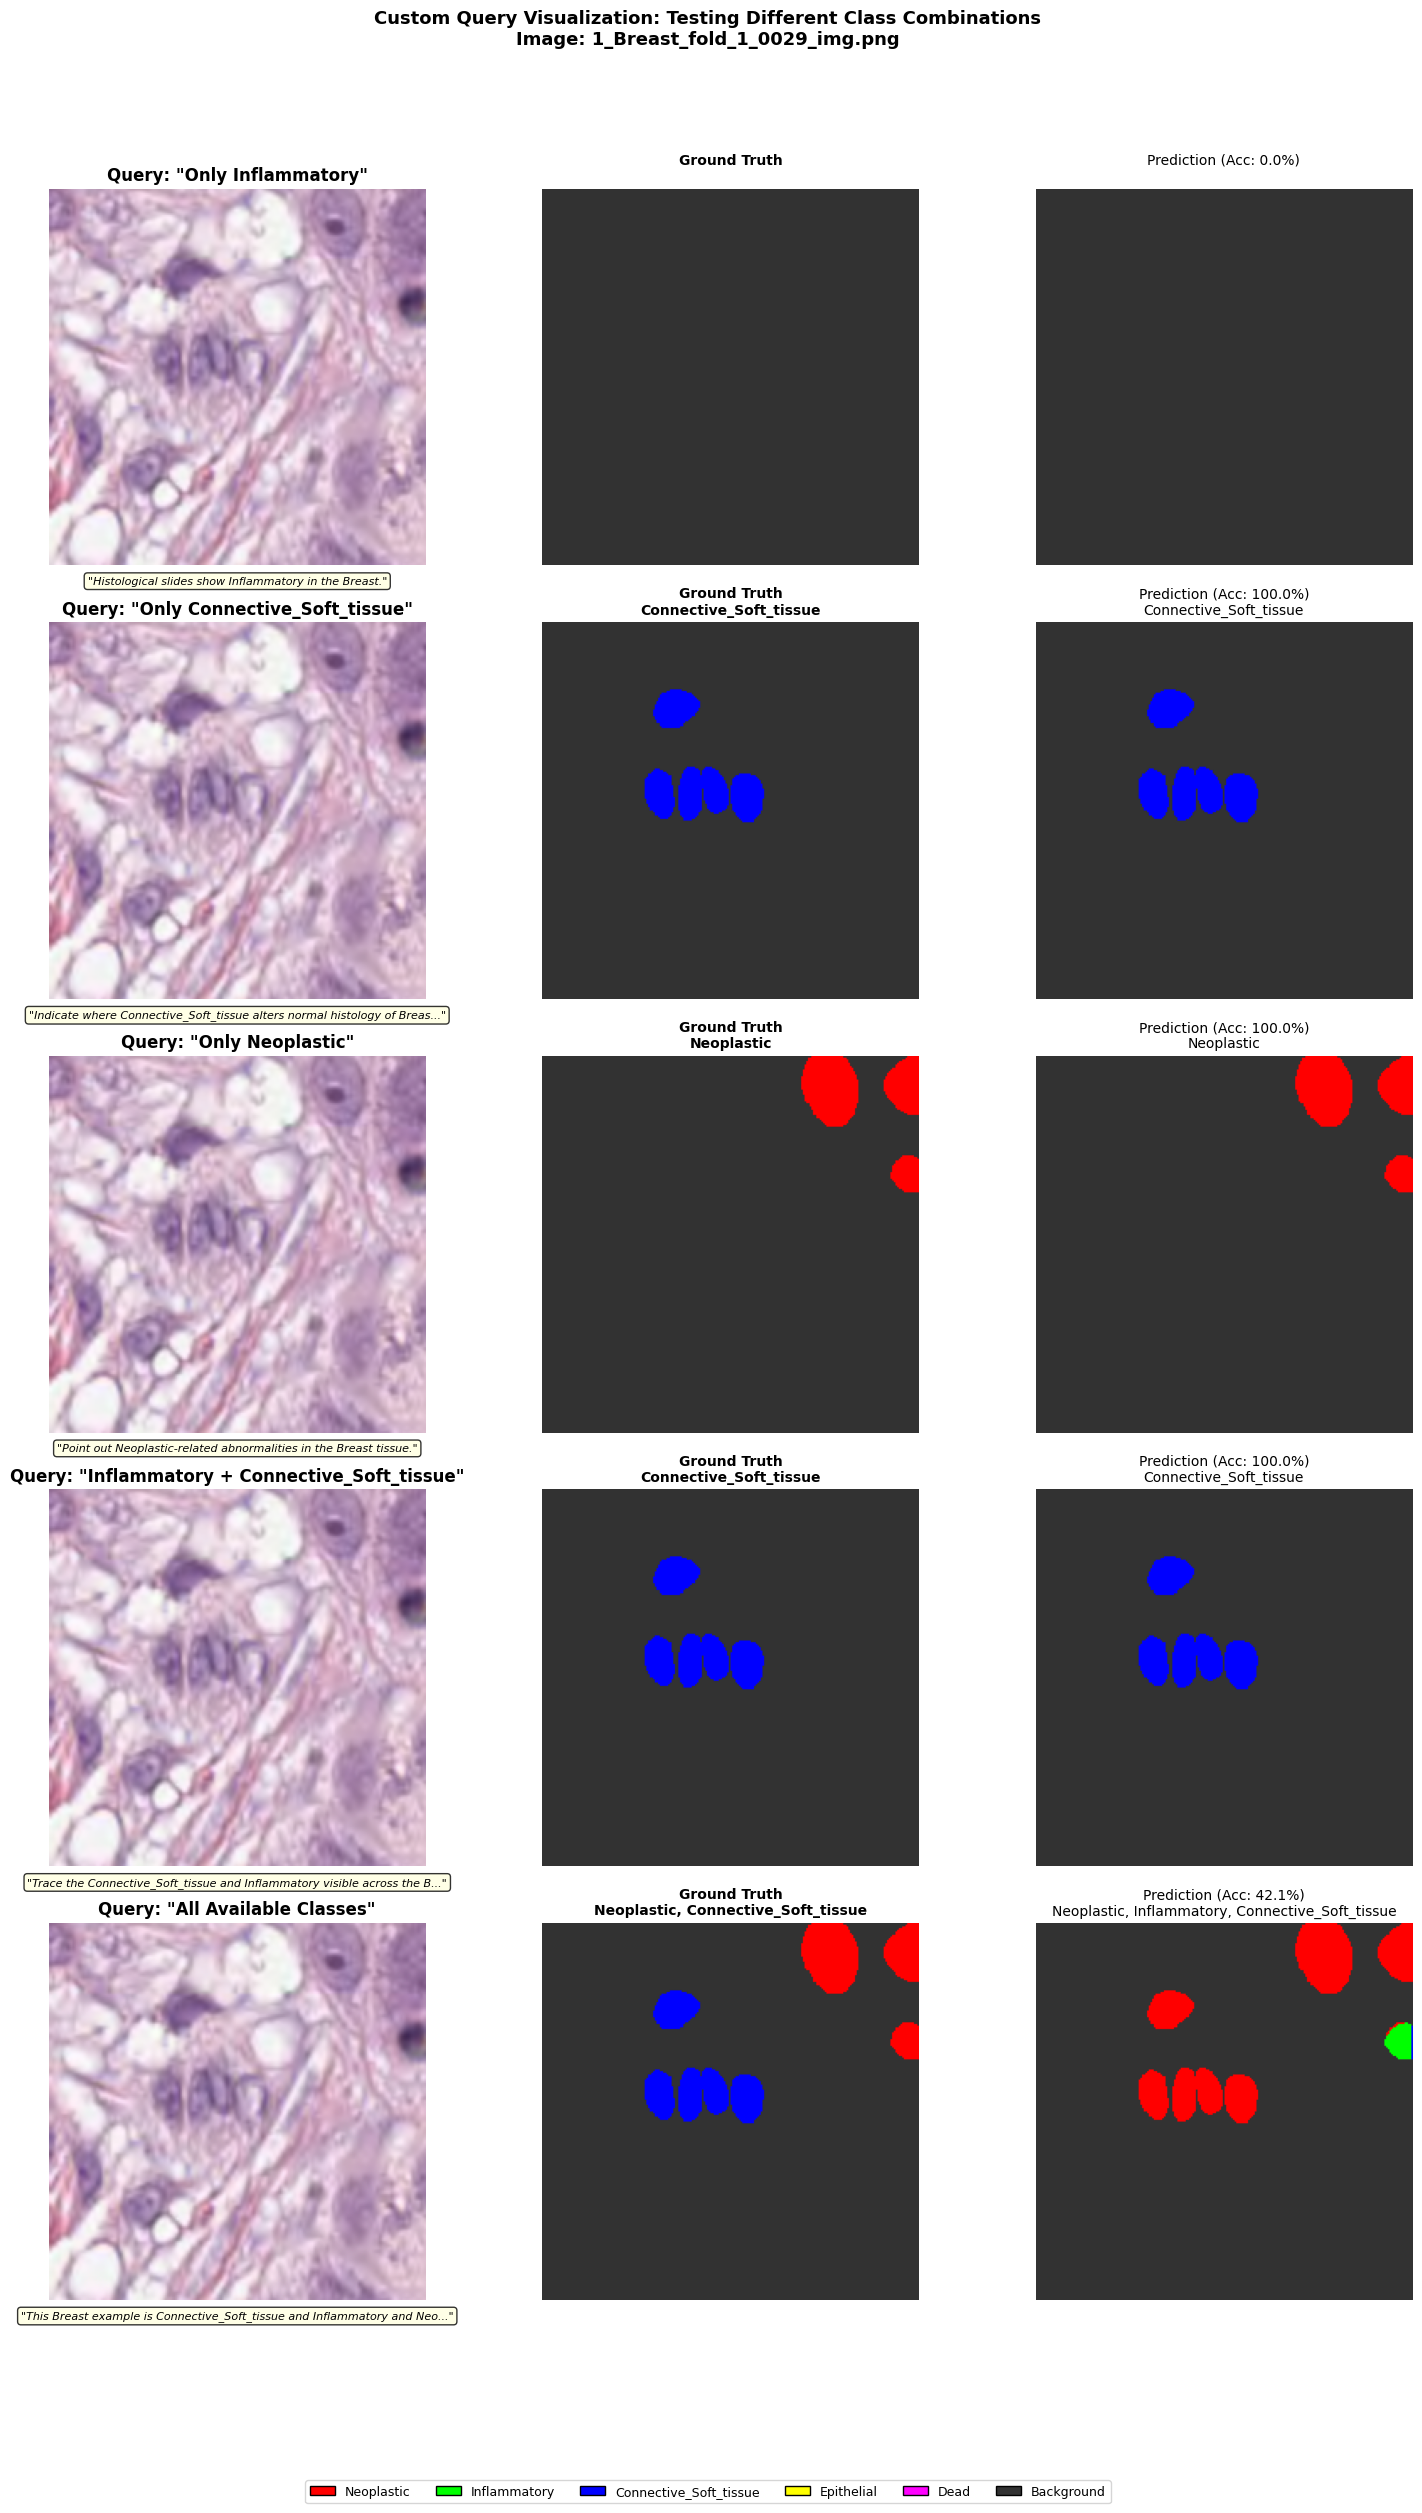


✓ Saved to 'class_combination_test2.png'

This demonstrates that the model can segment different regions
based on which classes are mentioned in the text query!
[Dataset] = using actual caption from dataset
[Generated] = using static caption format


In [24]:
# Cell: Example - Test Various Class Combinations on a Single Image
# Uses ACTUAL captions from dataset when available
print("=" * 70)
print("EXAMPLE: Testing Various Class Combinations")
print("Using ACTUAL CAPTIONS from dataset when available!")
print("=" * 70)

# Find a good image with multiple classes
test_image, test_classes = find_image_with_multiple_classes(val_df, min_classes=3)
print(f"\nTest image: {test_image}")
print(f"Classes in image: {test_classes}")

# Create diverse query combinations
test_queries = []

# Individual classes
for cls in test_classes[:3]:  # First 3 classes individually
    test_queries.append({
        'classes': [cls],
        'label': f'Only {cls}'
    })

# Two-class combinations
if len(test_classes) >= 2:
    test_queries.append({
        'classes': test_classes[:2],
        'label': f'{test_classes[0]} + {test_classes[1]}'
    })

# All classes
if len(test_classes) > 2:
    test_queries.append({
        'classes': test_classes,
        'label': 'All Available Classes'
    })

print(f"\nTesting {len(test_queries)} different queries:")
for i, q in enumerate(test_queries):
    print(f"  {i+1}. {q['label']}: {q['classes']}")

# Run visualization with dataframe for actual captions
visualize_custom_queries(
    model=model,
    image_path=test_image,
    queries_list=test_queries,
    dataframe=df,  # Pass dataframe for actual captions
    device=device,
    save_path='class_combination_test2.png'
)

print("\n" + "=" * 70)
print("This demonstrates that the model can segment different regions")
print("based on which classes are mentioned in the text query!")
print("[Dataset] = using actual caption from dataset")
print("[Generated] = using static caption format")
print("=" * 70)

In [ ]:
# Cell 15: Compare Predictions vs Ground Truth (Multi-Class)
def compare_multiclass_predictions_vs_gt(model, dataset, indices, device, num_classes=5):
    """
    Side-by-side comparison of predictions and ground truth using class index masks.
    """
    model.eval()
    
    num_samples = len(indices)
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    with torch.no_grad():
        for row, idx in enumerate(indices):
            sample = dataset[idx]
            image = sample['image'].unsqueeze(0).to(device)
            gt_mask = sample['mask'].numpy()  # [H, W] class indices
            query = sample['instruction']
            queried_classes = sample['queried_classes']
            
            # Prediction
            output = model(image, [query])
            logits = output['masks']  # [1, 5, H, W]
            pred_mask = torch.argmax(logits, dim=1)[0].cpu().numpy()  # [H, W]
            
            # Denormalize image for display
            img_display = sample['image'].permute(1, 2, 0).numpy()
            img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_display = np.clip(img_display, 0, 1)
            
            # Calculate per-class Dice for this sample
            sample_dice = []
            for c in range(num_classes):
                pred_c = (pred_mask == c).astype(float)
                gt_c = (gt_mask == c).astype(float)
                intersection = (pred_c * gt_c).sum()
                union = pred_c.sum() + gt_c.sum()
                dice_c = (2 * intersection + 1e-6) / (union + 1e-6) if union > 0 else 1.0
                sample_dice.append(dice_c)
            macro_dice = np.mean(sample_dice)
            
            # Colorize masks
            gt_rgb = colorize_mask(gt_mask)
            pred_rgb = colorize_mask(pred_mask)
            
            # Plot
            axes[row, 0].imshow(img_display)
            axes[row, 0].set_title('Input Image', fontsize=10)
            axes[row, 0].axis('off')
            
            axes[row, 1].imshow(gt_rgb)
            gt_classes = np.unique(gt_mask).tolist()
            axes[row, 1].set_title(f'Ground Truth\nClasses: {gt_classes}', fontsize=9)
            axes[row, 1].axis('off')
            
            axes[row, 2].imshow(pred_rgb)
            pred_classes = np.unique(pred_mask).tolist()
            axes[row, 2].set_title(f'Prediction (Dice={macro_dice:.3f})\nClasses: {pred_classes}', fontsize=9)
            axes[row, 2].axis('off')
            
            # Difference map (incorrect pixels)
            diff = (gt_mask != pred_mask).astype(float)
            axes[row, 3].imshow(diff, cmap='Reds')
            error_rate = diff.mean() * 100
            axes[row, 3].set_title(f'Errors ({error_rate:.1f}%)', fontsize=10)
            axes[row, 3].axis('off')
            
            # Add query label
            query_short = queried_classes[:35] + '...' if len(queried_classes) > 35 else queried_classes
            fig.text(0.02, (num_samples - row - 0.5) / num_samples, 
                     f'Query: {query_short}', fontsize=8, va='center',
                     bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    # Add legend
    legend_text = " | ".join([f'{i}:{name[:4]}' for i, name in enumerate(CLASS_NAMES)])
    plt.suptitle(f'Multi-Class Prediction vs Ground Truth\nLegend: {legend_text}', 
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(left=0.12)
    plt.savefig('multiclass_prediction_vs_gt.png', dpi=150, bbox_inches='tight')
    plt.show()

# Visualize samples
test_indices = list(range(min(6, len(val_dataset))))
compare_multiclass_predictions_vs_gt(model, val_dataset, test_indices, device, NUM_CLASSES)

Image: 1_Lung_fold_1_1025_img.png
Number of query instances: 6


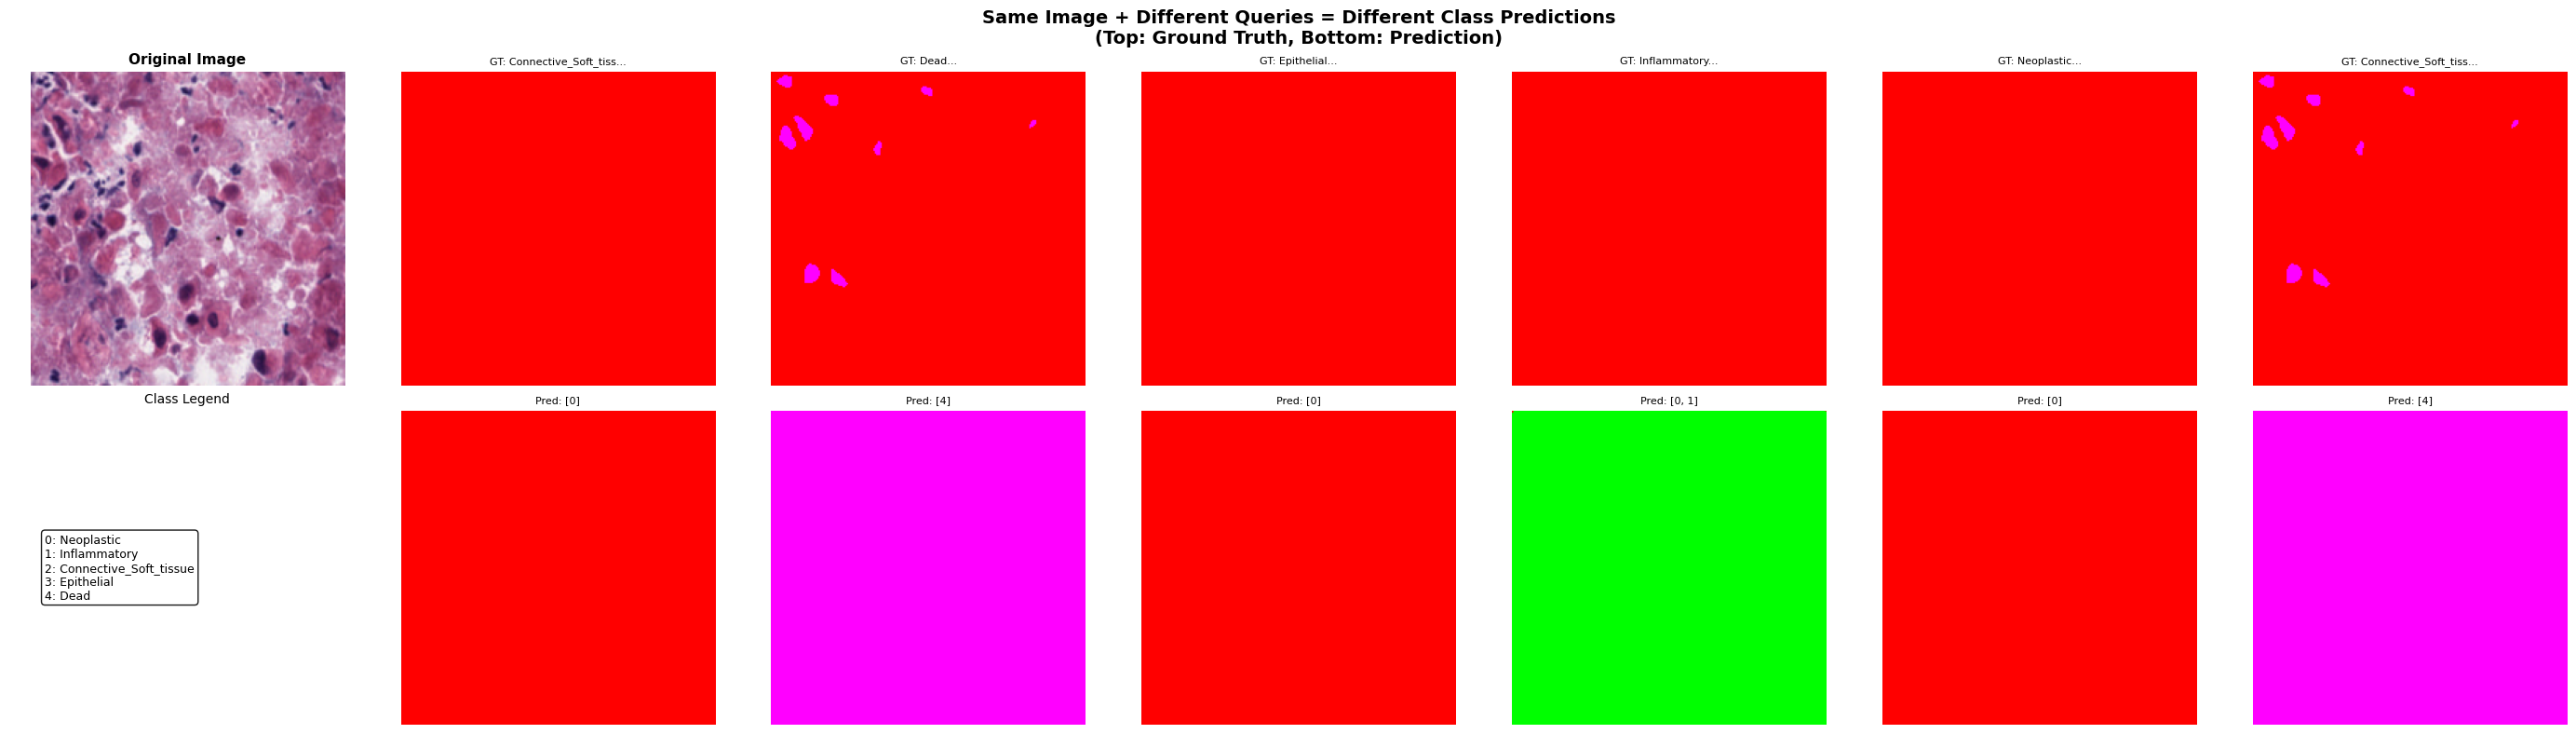

In [16]:
# Cell 16: Test Same Image with Different Queries (Key Demo - Multi-Class)
def demo_same_image_different_queries_multiclass(model, df, device, img_size=224):
    """
    The key demonstration: same image with different queries produces different class predictions.
    """
    model.eval()
    
    # Find an image with multiple instances
    image_counts = df['image_path'].value_counts()
    sample_image = image_counts.idxmax()  # Image with most instances
    instances = df[df['image_path'] == sample_image].head(6)
    
    print(f"Image: {sample_image}")
    print(f"Number of query instances: {len(instances)}")
    
    # Load image
    img_path = os.path.join('Dataset/multi_images', sample_image)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, (img_size, img_size))
    
    # Normalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_norm = (image_resized / 255.0 - mean) / std
    image_tensor = torch.from_numpy(image_norm).permute(2, 0, 1).float().unsqueeze(0).to(device)
    
    num_instances = len(instances)
    fig, axes = plt.subplots(2, num_instances + 1, figsize=(4 * (num_instances + 1), 8))
    
    # Original image
    axes[0, 0].imshow(image_resized)
    axes[0, 0].set_title('Original Image', fontsize=11, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Legend
    legend_text = '\n'.join([f'{i}: {name}' for i, name in enumerate(CLASS_NAMES)])
    axes[1, 0].text(0.1, 0.5, legend_text, fontsize=9, va='center', 
                    transform=axes[1, 0].transAxes,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    axes[1, 0].set_title('Class Legend', fontsize=10)
    axes[1, 0].axis('off')
    
    with torch.no_grad():
        for i, (_, row) in enumerate(instances.iterrows()):
            query = row['instruction']
            queried_classes = row['classes']
            
            # Prediction
            output = model(image_tensor, [query])
            logits = output['masks']
            pred_mask = torch.argmax(logits, dim=1)[0].cpu().numpy()
            
            # Load ground truth mask
            base_name = row['base_name']
            gt_mask = np.zeros((img_size, img_size), dtype=np.int64)
            
            for class_name in queried_classes.split(';'):
                class_name = class_name.strip()
                if class_name in CHANNEL_MAPPING:
                    ch = CHANNEL_MAPPING[class_name]
                    class_idx = CLASS_TO_IDX[class_name]
                    mask_path = f"Dataset/multi_masks/{base_name}_channel_{ch}_{class_name}.png"
                    if os.path.exists(mask_path):
                        m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                        m = cv2.resize(m, (img_size, img_size))
                        gt_mask[m > 127] = class_idx
            
            # Colorize
            gt_rgb = colorize_mask(gt_mask)
            pred_rgb = colorize_mask(pred_mask)
            
            # Row 1: Ground Truth
            axes[0, i + 1].imshow(gt_rgb)
            axes[0, i + 1].set_title(f'GT: {queried_classes[:20]}...', fontsize=8)
            axes[0, i + 1].axis('off')
            
            # Row 2: Prediction
            axes[1, i + 1].imshow(pred_rgb)
            pred_classes = np.unique(pred_mask).tolist()
            axes[1, i + 1].set_title(f'Pred: {pred_classes}', fontsize=8)
            axes[1, i + 1].axis('off')
    
    plt.suptitle('Same Image + Different Queries = Different Class Predictions\n(Top: Ground Truth, Bottom: Prediction)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('same_image_different_queries_multiclass.png', dpi=150, bbox_inches='tight')
    plt.show()

demo_same_image_different_queries_multiclass(model, val_df, device)

In [17]:
# Cell 17: Quantitative Analysis (Multi-Class)
print("=" * 80)
print("QUANTITATIVE ANALYSIS - MULTI-CLASS SEGMENTATION")
print("=" * 80)

# Evaluate on full validation set
model.eval()
all_dice_per_class = [[] for _ in range(NUM_CLASSES)]
all_iou_per_class = [[] for _ in range(NUM_CLASSES)]

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(val_loader, desc='Evaluating')):
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)  # [B, H, W]
        instructions = batch['instruction']
        
        outputs = model(images, instructions)
        logits = outputs['masks']  # [B, 5, H, W]
        
        # CRITICAL: Use argmax for predictions
        preds = torch.argmax(logits, dim=1)  # [B, H, W]
        
        # Debug: Log unique values for first batch
        if batch_idx == 0:
            print(f"\nDEBUG - First batch:")
            print(f"  torch.unique(preds): {torch.unique(preds).tolist()}")
            print(f"  torch.unique(masks): {torch.unique(masks).tolist()}")
        
        # Per-class Dice
        dice_per_class = compute_per_class_dice(logits, masks, NUM_CLASSES)
        _, iou_per_class = compute_mean_iou(logits, masks, NUM_CLASSES)
        
        for c in range(NUM_CLASSES):
            all_dice_per_class[c].append(dice_per_class[c])
            all_iou_per_class[c].append(iou_per_class[c])

# Compute final metrics
print("\n" + "=" * 80)
print("FINAL VALIDATION RESULTS")
print("=" * 80)

print("\nPer-Class Metrics:")
print("-" * 60)
print(f"{'Class':<25} {'Dice':>10} {'IoU':>10}")
print("-" * 60)

final_dice_per_class = []
final_iou_per_class = []

for c in range(NUM_CLASSES):
    mean_dice = np.mean(all_dice_per_class[c])
    std_dice = np.std(all_dice_per_class[c])
    mean_iou = np.mean(all_iou_per_class[c])
    std_iou = np.std(all_iou_per_class[c])
    
    final_dice_per_class.append(mean_dice)
    final_iou_per_class.append(mean_iou)
    
    print(f"{CLASS_NAMES[c]:<25} {mean_dice:>10.4f} {mean_iou:>10.4f}")

print("-" * 60)

# Macro averages
macro_dice = np.mean(final_dice_per_class)
macro_iou = np.mean(final_iou_per_class)

print(f"{'MACRO AVERAGE':<25} {macro_dice:>10.4f} {macro_iou:>10.4f}")
print("=" * 80)

# Bar chart visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['red', 'green', 'blue', 'orange', 'purple']

# Dice bar chart
bars1 = axes[0].bar(CLASS_NAMES, final_dice_per_class, color=colors, alpha=0.7, edgecolor='black')
axes[0].axhline(y=macro_dice, color='black', linestyle='--', linewidth=2, label=f'Macro: {macro_dice:.4f}')
axes[0].set_ylabel('Dice Score')
axes[0].set_title('Per-Class Dice Score')
axes[0].set_ylim(0, 1)
axes[0].legend()
for bar, dice in zip(bars1, final_dice_per_class):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{dice:.3f}', ha='center', va='bottom', fontsize=10)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# IoU bar chart
bars2 = axes[1].bar(CLASS_NAMES, final_iou_per_class, color=colors, alpha=0.7, edgecolor='black')
axes[1].axhline(y=macro_iou, color='black', linestyle='--', linewidth=2, label=f'Mean: {macro_iou:.4f}')
axes[1].set_ylabel('IoU Score')
axes[1].set_title('Per-Class IoU Score')
axes[1].set_ylim(0, 1)
axes[1].legend()
for bar, iou in zip(bars2, final_iou_per_class):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{iou:.3f}', ha='center', va='bottom', fontsize=10)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.suptitle('Multi-Class Segmentation Performance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('multiclass_quantitative_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Quantitative analysis complete!")

QUANTITATIVE ANALYSIS - MULTI-CLASS SEGMENTATION


Evaluating:   0%|          | 0/82 [00:00<?, ?it/s]


DEBUG - First batch:
  torch.unique(preds): [0, 1, 2, 3, 4]
  torch.unique(masks): [0, 1, 2, 255]


TypeError: cannot unpack non-iterable numpy.float64 object